# MultiClass-Classification-SentenceTransformer

Dataset contains text from works of fiction written by spooky authors of the public domain: Edgar Allan Poe, HP Lovecraft and Mary Shelley. The data was prepared by chunking larger texts into sentences using CoreNLP's MaxEnt sentence tokenizer, so you may notice the odd non-sentence here and there. Our objective is to accurately identify the author of the sentences in the data set.

### Import Libraries

In [29]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, auc,roc_auc_score
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score,classification_report,accuracy_score
from sklearn.metrics import precision_score,recall_score
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix
from sklearn import metrics

In [2]:
df=pd.read_csv("train_multi.csv")
df.dropna(inplace=True)
df.head()

,id,text,author
0,id26305,"This process, however, afforded me no means of...",EAP
1,id17569,It never once occurred to me that the fumbling...,HPL
2,id11008,"In his left hand was a gold snuff box, from wh...",EAP
3,id27763,How lovely is spring As we looked from Windsor...,MWS
4,id12958,"Finding nothing else, not even gold, the Super...",HPL


In [3]:
## No of unique labels with their distribution
df['author'].value_counts()

EAP    7900
MWS    6044
HPL    5635
Name: author, dtype: int64

> Dataset is almost Balanced with 3 classes

/home/azure/.pyenv/versions/mlflow_env/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='author', ylabel='count'>

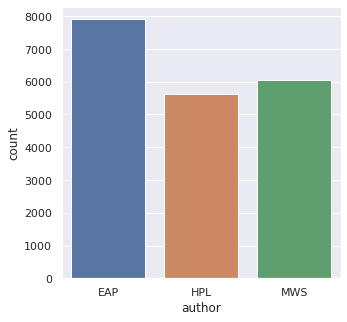

In [4]:
sns.set(rc={'figure.figsize':(5,5)})
sns.countplot(df['author'])

### Text Cleaning

In [5]:
from bs4 import BeautifulSoup
import re
def sanitize_text(document):
    if document == None:
        document = ""
    review_text = BeautifulSoup(document, 'html5lib').get_text()

    review_text = re.sub("[^a-zA-Z]", " ", review_text)
    review_text = re.sub(r'([a-z](?=[A-Z])|[A-Z](?=[A-Z][a-z]))', r'\1 ', review_text)

#     review_text = review_text.lower()
    review_text_list = review_text.split(" ")
    review_text_list = [x.strip() for x in review_text_list]
    review_text = " ".join(review_text_list)

    document = re.sub(' +', ' ', review_text).strip()
    return document
df['clean_text']=df['text'].apply(lambda x:sanitize_text(x))

In [6]:
possible_labels = df.author.unique()

label_dict = {}
for index, possible_label in enumerate(possible_labels):
    label_dict[possible_label] = index
label_dict

{'EAP': 0, 'HPL': 1, 'MWS': 2}

In [7]:
df['label'] = df.author.replace(label_dict)

### For Encoding

> We use 'stsb-roberta-large' from Sentence Transformer Model

In [8]:
from sentence_transformers import SentenceTransformer
model = SentenceTransformer('stsb-roberta-large')

2022-08-04 06:41:08.951981: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/lib:
2022-08-04 06:41:08.952027: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [9]:
embed = model.encode(df['clean_text'].tolist(),convert_to_tensor=False, convert_to_numpy=True,normalize_embeddings=True)

In [10]:
embed.shape

(19579, 1024)

In [11]:
x_train, x_test, y_train, y_test = train_test_split(embed, df['label'], test_size = .25, random_state = 18,stratify=df.label.values)

In [12]:
x_train.shape,x_test.shape

((14684, 1024), (4895, 1024))

/home/azure/.pyenv/versions/mlflow_env/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


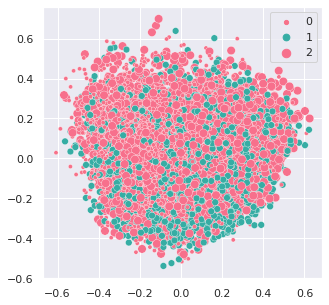

In [13]:
# plot the train features
from sklearn.decomposition import PCA
pca = PCA(n_components=2).fit(x_train)
data2D = pca.transform(x_train)
cmap = sns.cubehelix_palette(dark=.3, light=.8, as_cmap=True)
ax = sns.scatterplot(data2D[:,0], data2D[:,1],
hue=y_train.tolist(),size=y_train.tolist(),palette="husl")

### Random Forest

In [14]:
clf = RandomForestClassifier(n_estimators = 500, max_depth = 4, max_features = 3, bootstrap = True, random_state = 18)
clf.fit(x_train, y_train)
y_pred=clf.predict(x_test)
y_true=y_test.to_numpy()

In [16]:
print(classification_report(
    y_true,
    y_pred,
    output_dict=False,
    target_names= df['author'].unique()
))

              precision    recall  f1-score   support

         EAP       0.43      0.97      0.60      1975
         HPL       0.91      0.04      0.08      1409
         MWS       0.81      0.19      0.31      1511

    accuracy                           0.46      4895
   macro avg       0.72      0.40      0.33      4895
weighted avg       0.68      0.46      0.36      4895



### HyperParameter Tuning

In [17]:
## Fine tune RF Model
from hyperopt import fmin, tpe, hp, anneal, Trials,space_eval
from sklearn.model_selection import KFold,TimeSeriesSplit,StratifiedKFold
import numpy as np
from sklearn.metrics import make_scorer
from sklearn.model_selection import cross_val_score
import gc
import time


In [18]:
X_train=pd.DataFrame(x_train)
def objective(params):
    time1 = time.time()
    ### For Random Forest
    params = {
        'n_estimators': int(params['n_estimators']),
        'criterion': params['criterion'],
        'max_features': params['max_features'],
        'min_samples_split': int(params['min_samples_split']),
        'max_depth': int(params['max_depth']),
        'min_samples_leaf': int(params['min_samples_leaf'])
   
    }


    print("\n############## New Run ################")
    print(f"params = {params}")
    FOLDS = 7
    count=1
    skf = StratifiedKFold(n_splits=FOLDS, shuffle=True, random_state=42)

    tss = TimeSeriesSplit(n_splits=FOLDS)

    score_mean = 0
    for tr_idx, val_idx in tss.split(X_train, y_train):
        clf = RandomForestClassifier(random_state=4, verbose=True,**params,n_jobs=-1)

        X_tr, X_vl = X_train.iloc[tr_idx, :], X_train.iloc[val_idx, :]
        y_tr, y_vl = y_train.iloc[tr_idx], y_train.iloc[val_idx]
        
        clf.fit(X_tr, y_tr)
        y_pred = clf.predict(X_vl)
        score = f1_score( y_vl,y_pred,average='weighted')
        score_mean += score
        print(f'{count} CV - score: {round(score, 4)}')
        count += 1
    time2 = time.time() - time1
    print(f"Total Time Run: {round(time2 / 60,2)}")
    gc.collect()
    print(f'Mean F1-Score: {score_mean / FOLDS}')
    del X_tr, X_vl, y_tr, y_vl, clf, score
    return -(score_mean / FOLDS)



space = {
    # The maximum depth of a tree, same as GBM.
    # Used to control over-fitting as higher depth will allow model 
    # to learn relations very specific to a particular sample.
    # Should be tuned using CV.
    # Typical values: 3-10
    
    'n_estimators': hp.choice('n_estimators', list(range(100, 300, 1))),
    'criterion': hp.choice('criterion', ["gini", "entropy"]),
    'max_features': hp.choice('max_features', ["auto", "sqrt", "log2"]),
    "max_depth": hp.quniform("max_depth", 7, 23,1),
    
    
    # more increases accuracy, but may lead to overfitting.
    # num_leaves: the number of leaf nodes to use. Having a large number 
    # of leaves will improve accuracy, but will also lead to overfitting.
    'min_samples_leaf': hp.choice('min_samples_leaf', list(range(1, 25,1))),
    
    # specifies the minimum samples per leaf node.
    # the minimum number of samples (data) to group into a leaf. 
    # The parameter can greatly assist with overfitting: larger sample
    # sizes per leaf will reduce overfitting (but may lead to under-fitting).
    'min_samples_split': hp.choice('min_samples_split', list(range(2, 25, 1))),
       

}
# Set algoritm parameters
best = fmin(fn=objective,
            space=space,
            algo=tpe.suggest,
            max_evals=27)

# Print best parameters
best_params = space_eval(space, best)

                                                      
############## New Run ################
params = {'n_estimators': 281, 'criterion': 'entropy', 'max_features': 'log2', 'min_samples_split': 11, 'max_depth': 12, 'min_samples_leaf': 20}
  0%|          | 0/27 [00:00<?, ?trial/s, best loss=?]

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.

[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.1s

[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:    0.5s



1 CV - score: 0.5124                                  
  0%|          | 0/27 [00:01<?, ?trial/s, best loss=?]

[Parallel(n_jobs=-1)]: Done 281 out of 281 | elapsed:    0.9s finished

[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.

[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s

[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s

[Parallel(n_jobs=16)]: Done 281 out of 281 | elapsed:    0.1s finished

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.

[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.2s

[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:    0.9s



2 CV - score: 0.5783                                  
  0%|          | 0/27 [00:02<?, ?trial/s, best loss=?]

[Parallel(n_jobs=-1)]: Done 281 out of 281 | elapsed:    1.4s finished

[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.

[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s

[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s

[Parallel(n_jobs=16)]: Done 281 out of 281 | elapsed:    0.1s finished

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.

[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.2s

[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:    1.4s



3 CV - score: 0.5574                                  
  0%|          | 0/27 [00:05<?, ?trial/s, best loss=?]

[Parallel(n_jobs=-1)]: Done 281 out of 281 | elapsed:    2.2s finished

[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.

[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s

[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s

[Parallel(n_jobs=16)]: Done 281 out of 281 | elapsed:    0.1s finished

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.

[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.4s

[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:    1.9s



4 CV - score: 0.5824                                  
  0%|          | 0/27 [00:08<?, ?trial/s, best loss=?]

[Parallel(n_jobs=-1)]: Done 281 out of 281 | elapsed:    3.1s finished

[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.

[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s

[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s

[Parallel(n_jobs=16)]: Done 281 out of 281 | elapsed:    0.1s finished

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.

[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.4s

[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:    2.4s



5 CV - score: 0.5887                                  
  0%|          | 0/27 [00:12<?, ?trial/s, best loss=?]

[Parallel(n_jobs=-1)]: Done 281 out of 281 | elapsed:    4.0s finished

[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.

[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s

[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s

[Parallel(n_jobs=16)]: Done 281 out of 281 | elapsed:    0.1s finished

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.

[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.5s

[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:    3.0s



6 CV - score: 0.6076                                  
  0%|          | 0/27 [00:18<?, ?trial/s, best loss=?]

[Parallel(n_jobs=-1)]: Done 281 out of 281 | elapsed:    4.9s finished

[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.

[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s

[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s

[Parallel(n_jobs=16)]: Done 281 out of 281 | elapsed:    0.1s finished

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.

[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.7s

[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:    3.7s



7 CV - score: 0.573                                   
Total Time Run: 0.4                                   
  0%|          | 0/27 [00:24<?, ?trial/s, best loss=?]

[Parallel(n_jobs=-1)]: Done 281 out of 281 | elapsed:    6.0s finished

[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.

[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s

[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s

[Parallel(n_jobs=16)]: Done 281 out of 281 | elapsed:    0.1s finished



Mean F1-Score: 0.5714111093439767                     
                                                                                 
############## New Run ################
params = {'n_estimators': 152, 'criterion': 'entropy', 'max_features': 'log2', 'min_samples_split': 22, 'max_depth': 18, 'min_samples_leaf': 12}
  4%|▎         | 1/27 [00:24<10:38, 24.55s/trial, best loss: -0.5714111093439767]

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.

[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.1s



1 CV - score: 0.5355                                                             
  4%|▎         | 1/27 [00:25<10:38, 24.55s/trial, best loss: -0.5714111093439767]

[Parallel(n_jobs=-1)]: Done 152 out of 152 | elapsed:    0.5s finished

[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.

[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s

[Parallel(n_jobs=16)]: Done 152 out of 152 | elapsed:    0.1s finished

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.

[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.2s



2 CV - score: 0.5849                                                             
  4%|▎         | 1/27 [00:26<10:38, 24.55s/trial, best loss: -0.5714111093439767]

[Parallel(n_jobs=-1)]: Done 152 out of 152 | elapsed:    0.9s finished

[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.

[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s

[Parallel(n_jobs=16)]: Done 152 out of 152 | elapsed:    0.1s finished

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.

[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.3s



3 CV - score: 0.5696                                                             
  4%|▎         | 1/27 [00:27<10:38, 24.55s/trial, best loss: -0.5714111093439767]

[Parallel(n_jobs=-1)]: Done 152 out of 152 | elapsed:    1.4s finished

[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.

[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s

[Parallel(n_jobs=16)]: Done 152 out of 152 | elapsed:    0.1s finished

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.

[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.4s



4 CV - score: 0.5932                                                             
  4%|▎         | 1/27 [00:29<10:38, 24.55s/trial, best loss: -0.5714111093439767]

[Parallel(n_jobs=-1)]: Done 152 out of 152 | elapsed:    1.9s finished

[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.

[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s

[Parallel(n_jobs=16)]: Done 152 out of 152 | elapsed:    0.1s finished

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.

[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.5s



5 CV - score: 0.5933                                                             
  4%|▎         | 1/27 [00:32<10:38, 24.55s/trial, best loss: -0.5714111093439767]

[Parallel(n_jobs=-1)]: Done 152 out of 152 | elapsed:    2.5s finished

[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.

[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s

[Parallel(n_jobs=16)]: Done 152 out of 152 | elapsed:    0.1s finished

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.

[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.6s



6 CV - score: 0.6108                                                             
  4%|▎         | 1/27 [00:36<10:38, 24.55s/trial, best loss: -0.5714111093439767]

[Parallel(n_jobs=-1)]: Done 152 out of 152 | elapsed:    3.4s finished

[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.

[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s

[Parallel(n_jobs=16)]: Done 152 out of 152 | elapsed:    0.1s finished

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.

[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.7s



7 CV - score: 0.5789                                                             
Total Time Run: 0.26                                                             
  4%|▎         | 1/27 [00:40<10:38, 24.55s/trial, best loss: -0.5714111093439767]

[Parallel(n_jobs=-1)]: Done 152 out of 152 | elapsed:    3.7s finished

[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.

[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s

[Parallel(n_jobs=16)]: Done 152 out of 152 | elapsed:    0.1s finished



Mean F1-Score: 0.5808968532375118                                                
                                                                                 
############## New Run ################
params = {'n_estimators': 200, 'criterion': 'entropy', 'max_features': 'auto', 'min_samples_split': 20, 'max_depth': 12, 'min_samples_leaf': 7}
  7%|▋         | 2/27 [00:40<08:05, 19.40s/trial, best loss: -0.5808968532375118]

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.

[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.3s

[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:    1.4s



1 CV - score: 0.5639                                                             
  7%|▋         | 2/27 [00:42<08:05, 19.40s/trial, best loss: -0.5808968532375118]

[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    1.6s finished

[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.

[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s

[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s

[Parallel(n_jobs=16)]: Done 200 out of 200 | elapsed:    0.1s finished

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.

[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.5s

[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:    3.0s



2 CV - score: 0.5935                                                             
  7%|▋         | 2/27 [00:45<08:05, 19.40s/trial, best loss: -0.5808968532375118]

[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    3.6s finished

[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.

[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s

[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s

[Parallel(n_jobs=16)]: Done 200 out of 200 | elapsed:    0.1s finished

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.

[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.9s

[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:    4.9s



3 CV - score: 0.5766                                                             
  7%|▋         | 2/27 [00:51<08:05, 19.40s/trial, best loss: -0.5808968532375118]

[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    5.7s finished

[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.

[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s

[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s

[Parallel(n_jobs=16)]: Done 200 out of 200 | elapsed:    0.1s finished

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.

[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    1.2s

[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:    6.8s



4 CV - score: 0.59                                                               
  7%|▋         | 2/27 [01:00<08:05, 19.40s/trial, best loss: -0.5808968532375118]

[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    8.0s finished

[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.

[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s

[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s

[Parallel(n_jobs=16)]: Done 200 out of 200 | elapsed:    0.1s finished

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.

[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    1.6s

[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:    9.0s



5 CV - score: 0.6091                                                             
  7%|▋         | 2/27 [01:10<08:05, 19.40s/trial, best loss: -0.5808968532375118]

[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:   10.6s finished

[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.

[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s

[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s

[Parallel(n_jobs=16)]: Done 200 out of 200 | elapsed:    0.1s finished

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.

[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    2.0s

[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:   10.9s



6 CV - score: 0.6326                                                             
  7%|▋         | 2/27 [01:23<08:05, 19.40s/trial, best loss: -0.5808968532375118]

[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:   12.8s finished

[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.

[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s

[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s

[Parallel(n_jobs=16)]: Done 200 out of 200 | elapsed:    0.1s finished

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.

[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    2.4s

[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:   13.0s



7 CV - score: 0.5862                                                             
Total Time Run: 0.98                                                             
  7%|▋         | 2/27 [01:39<08:05, 19.40s/trial, best loss: -0.5808968532375118]

[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:   15.2s finished

[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.

[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s

[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s

[Parallel(n_jobs=16)]: Done 200 out of 200 | elapsed:    0.1s finished



Mean F1-Score: 0.5931444840270462                                                
                                                                                 
############## New Run ################
params = {'n_estimators': 233, 'criterion': 'entropy', 'max_features': 'auto', 'min_samples_split': 21, 'max_depth': 23, 'min_samples_leaf': 5}
 11%|█         | 3/27 [01:39<15:02, 37.61s/trial, best loss: -0.5931444840270462]

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.

[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.3s

[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:    1.4s



1 CV - score: 0.5692                                                             
 11%|█         | 3/27 [01:41<15:02, 37.61s/trial, best loss: -0.5931444840270462]

[Parallel(n_jobs=-1)]: Done 233 out of 233 | elapsed:    1.9s finished

[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.

[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s

[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s

[Parallel(n_jobs=16)]: Done 233 out of 233 | elapsed:    0.1s finished

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.

[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.6s

[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:    3.2s



2 CV - score: 0.5875                                                             
 11%|█         | 3/27 [01:46<15:02, 37.61s/trial, best loss: -0.5931444840270462]

[Parallel(n_jobs=-1)]: Done 233 out of 233 | elapsed:    4.3s finished

[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.

[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s

[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s

[Parallel(n_jobs=16)]: Done 233 out of 233 | elapsed:    0.1s finished

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.

[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.9s

[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:    5.2s



3 CV - score: 0.5781                                                             
 11%|█         | 3/27 [01:53<15:02, 37.61s/trial, best loss: -0.5931444840270462]

[Parallel(n_jobs=-1)]: Done 233 out of 233 | elapsed:    6.9s finished

[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.

[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s

[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s

[Parallel(n_jobs=16)]: Done 233 out of 233 | elapsed:    0.1s finished

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.

[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    1.3s

[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:    7.3s



4 CV - score: 0.5879                                                             
 11%|█         | 3/27 [02:03<15:02, 37.61s/trial, best loss: -0.5931444840270462]

[Parallel(n_jobs=-1)]: Done 233 out of 233 | elapsed:    9.8s finished

[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.

[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s

[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s

[Parallel(n_jobs=16)]: Done 233 out of 233 | elapsed:    0.1s finished

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.

[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    1.7s

[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:    9.6s



5 CV - score: 0.6038                                                             
 11%|█         | 3/27 [02:16<15:02, 37.61s/trial, best loss: -0.5931444840270462]

[Parallel(n_jobs=-1)]: Done 233 out of 233 | elapsed:   13.2s finished

[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.

[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s

[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s

[Parallel(n_jobs=16)]: Done 233 out of 233 | elapsed:    0.1s finished

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.

[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    2.1s

[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:   12.2s



6 CV - score: 0.6387                                                             
 11%|█         | 3/27 [02:33<15:02, 37.61s/trial, best loss: -0.5931444840270462]

[Parallel(n_jobs=-1)]: Done 233 out of 233 | elapsed:   16.5s finished

[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.

[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s

[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s

[Parallel(n_jobs=16)]: Done 233 out of 233 | elapsed:    0.1s finished

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.

[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    2.6s

[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:   15.1s



7 CV - score: 0.5999                                                             
Total Time Run: 1.24                                                             
 11%|█         | 3/27 [02:54<15:02, 37.61s/trial, best loss: -0.5931444840270462]

[Parallel(n_jobs=-1)]: Done 233 out of 233 | elapsed:   20.2s finished

[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.

[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s

[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s

[Parallel(n_jobs=16)]: Done 233 out of 233 | elapsed:    0.1s finished



Mean F1-Score: 0.5950430374512347                                                
                                                                                 
############## New Run ################
params = {'n_estimators': 189, 'criterion': 'gini', 'max_features': 'log2', 'min_samples_split': 20, 'max_depth': 21, 'min_samples_leaf': 7}
 15%|█▍        | 4/27 [02:54<20:02, 52.29s/trial, best loss: -0.5950430374512347]

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.

[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.1s



1 CV - score: 0.5393                                                             
 15%|█▍        | 4/27 [02:55<20:02, 52.29s/trial, best loss: -0.5950430374512347]

[Parallel(n_jobs=-1)]: Done 189 out of 189 | elapsed:    0.7s finished

[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.

[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s

[Parallel(n_jobs=16)]: Done 189 out of 189 | elapsed:    0.1s finished

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.

[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.1s



2 CV - score: 0.5845                                                             
 15%|█▍        | 4/27 [02:56<20:02, 52.29s/trial, best loss: -0.5950430374512347]

[Parallel(n_jobs=-1)]: Done 189 out of 189 | elapsed:    0.8s finished

[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.

[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s

[Parallel(n_jobs=16)]: Done 189 out of 189 | elapsed:    0.1s finished

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.

[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.2s



3 CV - score: 0.5662                                                             
 15%|█▍        | 4/27 [02:57<20:02, 52.29s/trial, best loss: -0.5950430374512347]

[Parallel(n_jobs=-1)]: Done 189 out of 189 | elapsed:    1.1s finished

[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.

[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s

[Parallel(n_jobs=16)]: Done 189 out of 189 | elapsed:    0.1s finished

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.

[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.3s



4 CV - score: 0.5833                                                             
 15%|█▍        | 4/27 [02:59<20:02, 52.29s/trial, best loss: -0.5950430374512347]

[Parallel(n_jobs=-1)]: Done 189 out of 189 | elapsed:    1.8s finished

[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.

[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s

[Parallel(n_jobs=16)]: Done 189 out of 189 | elapsed:    0.1s finished

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.

[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.3s



5 CV - score: 0.5908                                                             
 15%|█▍        | 4/27 [03:01<20:02, 52.29s/trial, best loss: -0.5950430374512347]

[Parallel(n_jobs=-1)]: Done 189 out of 189 | elapsed:    1.9s finished

[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.

[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s

[Parallel(n_jobs=16)]: Done 189 out of 189 | elapsed:    0.1s finished

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.

[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.3s



6 CV - score: 0.6214                                                             
 15%|█▍        | 4/27 [03:04<20:02, 52.29s/trial, best loss: -0.5950430374512347]

[Parallel(n_jobs=-1)]: Done 189 out of 189 | elapsed:    1.9s finished

[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.

[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s

[Parallel(n_jobs=16)]: Done 189 out of 189 | elapsed:    0.1s finished

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.

[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.4s



7 CV - score: 0.5833                                                             
Total Time Run: 0.2                                                              
 15%|█▍        | 4/27 [03:06<20:02, 52.29s/trial, best loss: -0.5950430374512347]

[Parallel(n_jobs=-1)]: Done 189 out of 189 | elapsed:    2.1s finished

[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.

[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s

[Parallel(n_jobs=16)]: Done 189 out of 189 | elapsed:    0.1s finished



Mean F1-Score: 0.5812632154927987                                                
                                                                                 
############## New Run ################
params = {'n_estimators': 189, 'criterion': 'entropy', 'max_features': 'sqrt', 'min_samples_split': 3, 'max_depth': 11, 'min_samples_leaf': 14}
 19%|█▊        | 5/27 [03:06<13:52, 37.85s/trial, best loss: -0.5950430374512347]

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.

[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.3s



1 CV - score: 0.5604                                                             
 19%|█▊        | 5/27 [03:09<13:52, 37.85s/trial, best loss: -0.5950430374512347]

[Parallel(n_jobs=-1)]: Done 189 out of 189 | elapsed:    2.2s finished

[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.

[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s

[Parallel(n_jobs=16)]: Done 189 out of 189 | elapsed:    0.1s finished

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.

[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.6s



2 CV - score: 0.5854                                                             
 19%|█▊        | 5/27 [03:13<13:52, 37.85s/trial, best loss: -0.5950430374512347]

[Parallel(n_jobs=-1)]: Done 189 out of 189 | elapsed:    4.5s finished

[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.

[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s

[Parallel(n_jobs=16)]: Done 189 out of 189 | elapsed:    0.1s finished

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.

[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    1.0s



3 CV - score: 0.5826                                                             
 19%|█▊        | 5/27 [03:20<13:52, 37.85s/trial, best loss: -0.5950430374512347]

[Parallel(n_jobs=-1)]: Done 189 out of 189 | elapsed:    6.8s finished

[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.

[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s

[Parallel(n_jobs=16)]: Done 189 out of 189 | elapsed:    0.1s finished

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.

[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    1.5s



4 CV - score: 0.5873                                                             
 19%|█▊        | 5/27 [03:29<13:52, 37.85s/trial, best loss: -0.5950430374512347]

[Parallel(n_jobs=-1)]: Done 189 out of 189 | elapsed:    8.7s finished

[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.

[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s

[Parallel(n_jobs=16)]: Done 189 out of 189 | elapsed:    0.1s finished

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.

[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    2.0s



5 CV - score: 0.6103                                                             
 19%|█▊        | 5/27 [03:42<13:52, 37.85s/trial, best loss: -0.5950430374512347]

[Parallel(n_jobs=-1)]: Done 189 out of 189 | elapsed:   12.9s finished

[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.

[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s

[Parallel(n_jobs=16)]: Done 189 out of 189 | elapsed:    0.1s finished

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.

[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    2.2s



6 CV - score: 0.6216                                                             
 19%|█▊        | 5/27 [03:58<13:52, 37.85s/trial, best loss: -0.5950430374512347]

[Parallel(n_jobs=-1)]: Done 189 out of 189 | elapsed:   15.1s finished

[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.

[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s

[Parallel(n_jobs=16)]: Done 189 out of 189 | elapsed:    0.1s finished

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.

[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    2.9s



7 CV - score: 0.5898                                                             
Total Time Run: 1.17                                                             
 19%|█▊        | 5/27 [04:17<13:52, 37.85s/trial, best loss: -0.5950430374512347]

[Parallel(n_jobs=-1)]: Done 189 out of 189 | elapsed:   18.5s finished

[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.

[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s

[Parallel(n_jobs=16)]: Done 189 out of 189 | elapsed:    0.1s finished



Mean F1-Score: 0.5910598218835664                                                
                                                                                 
############## New Run ################
params = {'n_estimators': 112, 'criterion': 'gini', 'max_features': 'sqrt', 'min_samples_split': 4, 'max_depth': 11, 'min_samples_leaf': 22}
 22%|██▏       | 6/27 [04:17<17:08, 48.99s/trial, best loss: -0.5950430374512347]

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.

[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.1s



1 CV - score: 0.5375                                                             
 22%|██▏       | 6/27 [04:17<17:08, 48.99s/trial, best loss: -0.5950430374512347]

[Parallel(n_jobs=-1)]: Done 112 out of 112 | elapsed:    0.5s finished

[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.

[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s

[Parallel(n_jobs=16)]: Done 112 out of 112 | elapsed:    0.1s finished

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.

[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.2s



2 CV - score: 0.5733                                                             
 22%|██▏       | 6/27 [04:18<17:08, 48.99s/trial, best loss: -0.5950430374512347]

[Parallel(n_jobs=-1)]: Done 112 out of 112 | elapsed:    0.8s finished

[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.

[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s

[Parallel(n_jobs=16)]: Done 112 out of 112 | elapsed:    0.1s finished

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.

[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.3s



3 CV - score: 0.5687                                                             
 22%|██▏       | 6/27 [04:20<17:08, 48.99s/trial, best loss: -0.5950430374512347]

[Parallel(n_jobs=-1)]: Done 112 out of 112 | elapsed:    1.1s finished

[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.

[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s

[Parallel(n_jobs=16)]: Done 112 out of 112 | elapsed:    0.1s finished

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.

[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.5s



4 CV - score: 0.5829                                                             
 22%|██▏       | 6/27 [04:22<17:08, 48.99s/trial, best loss: -0.5950430374512347]

[Parallel(n_jobs=-1)]: Done 112 out of 112 | elapsed:    2.1s finished

[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.

[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s

[Parallel(n_jobs=16)]: Done 112 out of 112 | elapsed:    0.1s finished

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.

[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.6s



5 CV - score: 0.5873                                                             
 22%|██▏       | 6/27 [04:25<17:08, 48.99s/trial, best loss: -0.5950430374512347]

[Parallel(n_jobs=-1)]: Done 112 out of 112 | elapsed:    2.9s finished

[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.

[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s

[Parallel(n_jobs=16)]: Done 112 out of 112 | elapsed:    0.1s finished

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.

[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.6s



6 CV - score: 0.6228                                                             
 22%|██▏       | 6/27 [04:29<17:08, 48.99s/trial, best loss: -0.5950430374512347]

[Parallel(n_jobs=-1)]: Done 112 out of 112 | elapsed:    3.4s finished

[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.

[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s

[Parallel(n_jobs=16)]: Done 112 out of 112 | elapsed:    0.1s finished

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.

[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.8s



7 CV - score: 0.577                                                              
Total Time Run: 0.26                                                             
 22%|██▏       | 6/27 [04:32<17:08, 48.99s/trial, best loss: -0.5950430374512347]

[Parallel(n_jobs=-1)]: Done 112 out of 112 | elapsed:    3.5s finished

[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.

[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s

[Parallel(n_jobs=16)]: Done 112 out of 112 | elapsed:    0.1s finished



Mean F1-Score: 0.5785039061526843                                                
                                                                                 
############## New Run ################
params = {'n_estimators': 179, 'criterion': 'gini', 'max_features': 'auto', 'min_samples_split': 13, 'max_depth': 14, 'min_samples_leaf': 10}
 26%|██▌       | 7/27 [04:32<12:41, 38.09s/trial, best loss: -0.5950430374512347]

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.

[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.2s



1 CV - score: 0.559                                                              
 26%|██▌       | 7/27 [04:34<12:41, 38.09s/trial, best loss: -0.5950430374512347]

[Parallel(n_jobs=-1)]: Done 179 out of 179 | elapsed:    1.0s finished

[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.

[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s

[Parallel(n_jobs=16)]: Done 179 out of 179 | elapsed:    0.1s finished

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.

[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.3s



2 CV - score: 0.5847                                                             
 26%|██▌       | 7/27 [04:36<12:41, 38.09s/trial, best loss: -0.5950430374512347]

[Parallel(n_jobs=-1)]: Done 179 out of 179 | elapsed:    1.8s finished

[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.

[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s

[Parallel(n_jobs=16)]: Done 179 out of 179 | elapsed:    0.1s finished

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.

[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.4s



3 CV - score: 0.5822                                                             
 26%|██▌       | 7/27 [04:38<12:41, 38.09s/trial, best loss: -0.5950430374512347]

[Parallel(n_jobs=-1)]: Done 179 out of 179 | elapsed:    2.2s finished

[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.

[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s

[Parallel(n_jobs=16)]: Done 179 out of 179 | elapsed:    0.1s finished

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.

[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.4s



4 CV - score: 0.5915                                                             
 26%|██▌       | 7/27 [04:41<12:41, 38.09s/trial, best loss: -0.5950430374512347]

[Parallel(n_jobs=-1)]: Done 179 out of 179 | elapsed:    3.0s finished

[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.

[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s

[Parallel(n_jobs=16)]: Done 179 out of 179 | elapsed:    0.1s finished

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.

[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.8s



5 CV - score: 0.6063                                                             
 26%|██▌       | 7/27 [04:47<12:41, 38.09s/trial, best loss: -0.5950430374512347]

[Parallel(n_jobs=-1)]: Done 179 out of 179 | elapsed:    5.2s finished

[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.

[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s

[Parallel(n_jobs=16)]: Done 179 out of 179 | elapsed:    0.1s finished

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.

[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.7s



6 CV - score: 0.628                                                              
 26%|██▌       | 7/27 [04:53<12:41, 38.09s/trial, best loss: -0.5950430374512347]

[Parallel(n_jobs=-1)]: Done 179 out of 179 | elapsed:    5.6s finished

[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.

[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s

[Parallel(n_jobs=16)]: Done 179 out of 179 | elapsed:    0.1s finished

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.

[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    1.0s



7 CV - score: 0.5889                                                             
Total Time Run: 0.46                                                             
 26%|██▌       | 7/27 [05:00<12:41, 38.09s/trial, best loss: -0.5950430374512347]

[Parallel(n_jobs=-1)]: Done 179 out of 179 | elapsed:    7.2s finished

[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.

[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s

[Parallel(n_jobs=16)]: Done 179 out of 179 | elapsed:    0.1s finished



Mean F1-Score: 0.5915078645805701                                                
                                                                                 
############## New Run ################
params = {'n_estimators': 210, 'criterion': 'gini', 'max_features': 'auto', 'min_samples_split': 8, 'max_depth': 7, 'min_samples_leaf': 17}
 30%|██▉       | 8/27 [05:00<11:02, 34.84s/trial, best loss: -0.5950430374512347]

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.

[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.1s

[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:    0.7s

[Parallel(n_jobs=-1)]: Done 210 out of 210 | elapsed:    0.8s finished

[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.

[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s



1 CV - score: 0.5445                                                             
 30%|██▉       | 8/27 [05:01<11:02, 34.84s/trial, best loss: -0.5950430374512347]

[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s

[Parallel(n_jobs=16)]: Done 210 out of 210 | elapsed:    0.1s finished

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.

[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.2s

[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:    1.1s



2 CV - score: 0.5703                                                             
 30%|██▉       | 8/27 [05:03<11:02, 34.84s/trial, best loss: -0.5950430374512347]

[Parallel(n_jobs=-1)]: Done 210 out of 210 | elapsed:    1.3s finished

[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.

[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s

[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s

[Parallel(n_jobs=16)]: Done 210 out of 210 | elapsed:    0.1s finished

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.

[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.3s

[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:    1.8s



3 CV - score: 0.5518                                                             
 30%|██▉       | 8/27 [05:06<11:02, 34.84s/trial, best loss: -0.5950430374512347]

[Parallel(n_jobs=-1)]: Done 210 out of 210 | elapsed:    2.3s finished

[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.

[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s

[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s

[Parallel(n_jobs=16)]: Done 210 out of 210 | elapsed:    0.1s finished

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.

[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.6s

[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:    3.0s



4 CV - score: 0.575                                                              
 30%|██▉       | 8/27 [05:10<11:02, 34.84s/trial, best loss: -0.5950430374512347]

[Parallel(n_jobs=-1)]: Done 210 out of 210 | elapsed:    3.7s finished

[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.

[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s

[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s

[Parallel(n_jobs=16)]: Done 210 out of 210 | elapsed:    0.1s finished

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.

[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.5s

[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:    3.5s



5 CV - score: 0.5847                                                             
 30%|██▉       | 8/27 [05:14<11:02, 34.84s/trial, best loss: -0.5950430374512347]

[Parallel(n_jobs=-1)]: Done 210 out of 210 | elapsed:    4.1s finished

[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.

[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s

[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s

[Parallel(n_jobs=16)]: Done 210 out of 210 | elapsed:    0.1s finished

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.

[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.5s

[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:    4.2s



6 CV - score: 0.6075                                                             
 30%|██▉       | 8/27 [05:19<11:02, 34.84s/trial, best loss: -0.5950430374512347]

[Parallel(n_jobs=-1)]: Done 210 out of 210 | elapsed:    5.1s finished

[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.

[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s

[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s

[Parallel(n_jobs=16)]: Done 210 out of 210 | elapsed:    0.1s finished

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.

[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.7s

[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:    4.4s



7 CV - score: 0.5559                                                             
Total Time Run: 0.41                                                             
 30%|██▉       | 8/27 [05:25<11:02, 34.84s/trial, best loss: -0.5950430374512347]

[Parallel(n_jobs=-1)]: Done 210 out of 210 | elapsed:    5.3s finished

[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.

[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s

[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s

[Parallel(n_jobs=16)]: Done 210 out of 210 | elapsed:    0.1s finished



Mean F1-Score: 0.5699371717898295                                                
                                                                                 
############## New Run ################
params = {'n_estimators': 274, 'criterion': 'gini', 'max_features': 'sqrt', 'min_samples_split': 9, 'max_depth': 16, 'min_samples_leaf': 4}
 33%|███▎      | 9/27 [05:25<09:30, 31.70s/trial, best loss: -0.5950430374512347]

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.

[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.1s

[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:    0.8s



1 CV - score: 0.5637                                                             
 33%|███▎      | 9/27 [05:27<09:30, 31.70s/trial, best loss: -0.5950430374512347]

[Parallel(n_jobs=-1)]: Done 274 out of 274 | elapsed:    1.4s finished

[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.

[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s

[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s

[Parallel(n_jobs=16)]: Done 274 out of 274 | elapsed:    0.2s finished

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.

[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.3s

[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:    2.1s



2 CV - score: 0.591                                                              
 33%|███▎      | 9/27 [05:30<09:30, 31.70s/trial, best loss: -0.5950430374512347]

[Parallel(n_jobs=-1)]: Done 274 out of 274 | elapsed:    3.0s finished

[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.

[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s

[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s

[Parallel(n_jobs=16)]: Done 274 out of 274 | elapsed:    0.1s finished

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.

[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.5s

[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:    3.0s



3 CV - score: 0.5816                                                             
 33%|███▎      | 9/27 [05:35<09:30, 31.70s/trial, best loss: -0.5950430374512347]

[Parallel(n_jobs=-1)]: Done 274 out of 274 | elapsed:    4.5s finished

[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.

[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s

[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s

[Parallel(n_jobs=16)]: Done 274 out of 274 | elapsed:    0.2s finished

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.

[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.5s

[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:    4.3s



4 CV - score: 0.5975                                                             
 33%|███▎      | 9/27 [05:42<09:30, 31.70s/trial, best loss: -0.5950430374512347]

[Parallel(n_jobs=-1)]: Done 274 out of 274 | elapsed:    6.5s finished

[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.

[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s

[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s

[Parallel(n_jobs=16)]: Done 274 out of 274 | elapsed:    0.2s finished

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.

[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.7s

[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:    4.2s



5 CV - score: 0.6051                                                             
 33%|███▎      | 9/27 [05:50<09:30, 31.70s/trial, best loss: -0.5950430374512347]

[Parallel(n_jobs=-1)]: Done 274 out of 274 | elapsed:    7.5s finished

[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.

[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s

[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s

[Parallel(n_jobs=16)]: Done 274 out of 274 | elapsed:    0.2s finished

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.

[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    1.1s

[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:    6.5s



6 CV - score: 0.6368                                                             
 33%|███▎      | 9/27 [06:00<09:30, 31.70s/trial, best loss: -0.5950430374512347]

[Parallel(n_jobs=-1)]: Done 274 out of 274 | elapsed:    9.8s finished

[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.

[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s

[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s

[Parallel(n_jobs=16)]: Done 274 out of 274 | elapsed:    0.2s finished

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.

[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    1.0s

[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:    7.5s



7 CV - score: 0.5916                                                             
Total Time Run: 0.77                                                             
 33%|███▎      | 9/27 [06:11<09:30, 31.70s/trial, best loss: -0.5950430374512347]

[Parallel(n_jobs=-1)]: Done 274 out of 274 | elapsed:   11.0s finished

[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.

[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s

[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s

[Parallel(n_jobs=16)]: Done 274 out of 274 | elapsed:    0.2s finished



Mean F1-Score: 0.5953460782557423                                                
                                                                                  
############## New Run ################
params = {'n_estimators': 228, 'criterion': 'entropy', 'max_features': 'sqrt', 'min_samples_split': 3, 'max_depth': 8, 'min_samples_leaf': 19}
 37%|███▋      | 10/27 [06:12<10:16, 36.26s/trial, best loss: -0.5953460782557423]

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.

[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.3s

[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:    1.9s



1 CV - score: 0.5481                                                              
 37%|███▋      | 10/27 [06:14<10:16, 36.26s/trial, best loss: -0.5953460782557423]

[Parallel(n_jobs=-1)]: Done 228 out of 228 | elapsed:    2.4s finished

[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.

[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s

[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s

[Parallel(n_jobs=16)]: Done 228 out of 228 | elapsed:    0.1s finished

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.

[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.5s

[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:    3.4s



2 CV - score: 0.5719                                                              
 37%|███▋      | 10/27 [06:19<10:16, 36.26s/trial, best loss: -0.5953460782557423]

[Parallel(n_jobs=-1)]: Done 228 out of 228 | elapsed:    4.5s finished

[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.

[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s

[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s

[Parallel(n_jobs=16)]: Done 228 out of 228 | elapsed:    0.1s finished

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.

[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.7s

[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:    5.6s



3 CV - score: 0.5667                                                              
 37%|███▋      | 10/27 [06:27<10:16, 36.26s/trial, best loss: -0.5953460782557423]

[Parallel(n_jobs=-1)]: Done 228 out of 228 | elapsed:    7.4s finished

[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.

[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s

[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s

[Parallel(n_jobs=16)]: Done 228 out of 228 | elapsed:    0.1s finished

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.

[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    1.1s

[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:    6.9s



4 CV - score: 0.5723                                                              
 37%|███▋      | 10/27 [06:37<10:16, 36.26s/trial, best loss: -0.5953460782557423]

[Parallel(n_jobs=-1)]: Done 228 out of 228 | elapsed:    9.6s finished

[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.

[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s

[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s

[Parallel(n_jobs=16)]: Done 228 out of 228 | elapsed:    0.1s finished

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.

[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    1.6s

[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:   10.2s



5 CV - score: 0.5954                                                              
 37%|███▋      | 10/27 [06:50<10:16, 36.26s/trial, best loss: -0.5953460782557423]

[Parallel(n_jobs=-1)]: Done 228 out of 228 | elapsed:   13.5s finished

[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.

[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s

[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s

[Parallel(n_jobs=16)]: Done 228 out of 228 | elapsed:    0.1s finished

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.

[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    1.7s

[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:   11.1s



6 CV - score: 0.6128                                                              
 37%|███▋      | 10/27 [07:06<10:16, 36.26s/trial, best loss: -0.5953460782557423]

[Parallel(n_jobs=-1)]: Done 228 out of 228 | elapsed:   15.4s finished

[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.

[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s

[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s

[Parallel(n_jobs=16)]: Done 228 out of 228 | elapsed:    0.1s finished

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.

[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    2.3s

[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:   14.2s



7 CV - score: 0.5662                                                              
Total Time Run: 1.22                                                              
 37%|███▋      | 10/27 [07:25<10:16, 36.26s/trial, best loss: -0.5953460782557423]

[Parallel(n_jobs=-1)]: Done 228 out of 228 | elapsed:   18.1s finished

[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.

[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s

[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s

[Parallel(n_jobs=16)]: Done 228 out of 228 | elapsed:    0.1s finished



Mean F1-Score: 0.576204384601488                                                  
                                                                                  
############## New Run ################
params = {'n_estimators': 197, 'criterion': 'entropy', 'max_features': 'log2', 'min_samples_split': 19, 'max_depth': 12, 'min_samples_leaf': 19}
 41%|████      | 11/27 [07:25<12:41, 47.58s/trial, best loss: -0.5953460782557423]

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.

[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.1s



1 CV - score: 0.5178                                                              
 41%|████      | 11/27 [07:26<12:41, 47.58s/trial, best loss: -0.5953460782557423]

[Parallel(n_jobs=-1)]: Done 197 out of 197 | elapsed:    0.8s finished

[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.

[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s

[Parallel(n_jobs=16)]: Done 197 out of 197 | elapsed:    0.1s finished

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.

[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.3s



2 CV - score: 0.5662                                                              
 41%|████      | 11/27 [07:28<12:41, 47.58s/trial, best loss: -0.5953460782557423]

[Parallel(n_jobs=-1)]: Done 197 out of 197 | elapsed:    1.7s finished

[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.

[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s

[Parallel(n_jobs=16)]: Done 197 out of 197 | elapsed:    0.1s finished

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.

[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.3s



3 CV - score: 0.5546                                                              
 41%|████      | 11/27 [07:30<12:41, 47.58s/trial, best loss: -0.5953460782557423]

[Parallel(n_jobs=-1)]: Done 197 out of 197 | elapsed:    2.3s finished

[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.

[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s

[Parallel(n_jobs=16)]: Done 197 out of 197 | elapsed:    0.1s finished

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.

[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.6s



4 CV - score: 0.5701                                                              
 41%|████      | 11/27 [07:34<12:41, 47.58s/trial, best loss: -0.5953460782557423]

[Parallel(n_jobs=-1)]: Done 197 out of 197 | elapsed:    3.3s finished

[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.

[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s

[Parallel(n_jobs=16)]: Done 197 out of 197 | elapsed:    0.1s finished

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.

[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.5s



5 CV - score: 0.5933                                                              
 41%|████      | 11/27 [07:39<12:41, 47.58s/trial, best loss: -0.5953460782557423]

[Parallel(n_jobs=-1)]: Done 197 out of 197 | elapsed:    4.7s finished

[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.

[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s

[Parallel(n_jobs=16)]: Done 197 out of 197 | elapsed:    0.1s finished

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.

[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.6s



6 CV - score: 0.6017                                                              
 41%|████      | 11/27 [07:44<12:41, 47.58s/trial, best loss: -0.5953460782557423]

[Parallel(n_jobs=-1)]: Done 197 out of 197 | elapsed:    4.5s finished

[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.

[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s

[Parallel(n_jobs=16)]: Done 197 out of 197 | elapsed:    0.1s finished

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.

[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.7s



7 CV - score: 0.5727                                                              
Total Time Run: 0.43                                                              
 41%|████      | 11/27 [07:50<12:41, 47.58s/trial, best loss: -0.5953460782557423]

[Parallel(n_jobs=-1)]: Done 197 out of 197 | elapsed:    6.3s finished

[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.

[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s

[Parallel(n_jobs=16)]: Done 197 out of 197 | elapsed:    0.1s finished



Mean F1-Score: 0.5680654515999969                                                 
                                                                                  
############## New Run ################
params = {'n_estimators': 217, 'criterion': 'gini', 'max_features': 'auto', 'min_samples_split': 14, 'max_depth': 22, 'min_samples_leaf': 22}
 44%|████▍     | 12/27 [07:51<10:14, 40.96s/trial, best loss: -0.5953460782557423]

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.

[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.1s

[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:    0.7s

[Parallel(n_jobs=-1)]: Done 217 out of 217 | elapsed:    0.8s finished

[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.

[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s



1 CV - score: 0.5424                                                              
 44%|████▍     | 12/27 [07:52<10:14, 40.96s/trial, best loss: -0.5953460782557423]

[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s

[Parallel(n_jobs=16)]: Done 217 out of 217 | elapsed:    0.1s finished

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.

[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.2s

[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:    1.6s



2 CV - score: 0.5748                                                              
 44%|████▍     | 12/27 [07:54<10:14, 40.96s/trial, best loss: -0.5953460782557423]

[Parallel(n_jobs=-1)]: Done 217 out of 217 | elapsed:    1.9s finished

[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.

[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s

[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s

[Parallel(n_jobs=16)]: Done 217 out of 217 | elapsed:    0.1s finished

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.

[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.3s

[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:    1.8s



3 CV - score: 0.5692                                                              
 44%|████▍     | 12/27 [07:57<10:14, 40.96s/trial, best loss: -0.5953460782557423]

[Parallel(n_jobs=-1)]: Done 217 out of 217 | elapsed:    2.5s finished

[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.

[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s

[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s

[Parallel(n_jobs=16)]: Done 217 out of 217 | elapsed:    0.1s finished

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.

[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.4s

[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:    3.4s



4 CV - score: 0.581                                                               
 44%|████▍     | 12/27 [08:01<10:14, 40.96s/trial, best loss: -0.5953460782557423]

[Parallel(n_jobs=-1)]: Done 217 out of 217 | elapsed:    4.2s finished

[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.

[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s

[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s

[Parallel(n_jobs=16)]: Done 217 out of 217 | elapsed:    0.1s finished

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.

[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.6s

[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:    3.3s



5 CV - score: 0.6035                                                              
 44%|████▍     | 12/27 [08:06<10:14, 40.96s/trial, best loss: -0.5953460782557423]

[Parallel(n_jobs=-1)]: Done 217 out of 217 | elapsed:    4.2s finished

[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.

[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s

[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s

[Parallel(n_jobs=16)]: Done 217 out of 217 | elapsed:    0.1s finished

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.

[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.6s

[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:    5.0s



6 CV - score: 0.6201                                                              
 44%|████▍     | 12/27 [08:12<10:14, 40.96s/trial, best loss: -0.5953460782557423]

[Parallel(n_jobs=-1)]: Done 217 out of 217 | elapsed:    6.4s finished

[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.

[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s

[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s

[Parallel(n_jobs=16)]: Done 217 out of 217 | elapsed:    0.1s finished

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.

[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.8s

[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:    5.7s



7 CV - score: 0.5772                                                              
Total Time Run: 0.49                                                              
 44%|████▍     | 12/27 [08:20<10:14, 40.96s/trial, best loss: -0.5953460782557423]

[Parallel(n_jobs=-1)]: Done 217 out of 217 | elapsed:    7.2s finished

[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.

[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s

[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s

[Parallel(n_jobs=16)]: Done 217 out of 217 | elapsed:    0.1s finished



Mean F1-Score: 0.5811751976257578                                                 
                                                                                  
############## New Run ################
params = {'n_estimators': 262, 'criterion': 'entropy', 'max_features': 'sqrt', 'min_samples_split': 3, 'max_depth': 23, 'min_samples_leaf': 16}
 48%|████▊     | 13/27 [08:20<08:44, 37.47s/trial, best loss: -0.5953460782557423]

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.

[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.3s

[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:    2.0s



1 CV - score: 0.5648                                                              
 48%|████▊     | 13/27 [08:23<08:44, 37.47s/trial, best loss: -0.5953460782557423]

[Parallel(n_jobs=-1)]: Done 262 out of 262 | elapsed:    3.0s finished

[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.

[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s

[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s

[Parallel(n_jobs=16)]: Done 262 out of 262 | elapsed:    0.1s finished

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.

[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.6s

[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:    3.4s



2 CV - score: 0.5987                                                              
 48%|████▊     | 13/27 [08:29<08:44, 37.47s/trial, best loss: -0.5953460782557423]

[Parallel(n_jobs=-1)]: Done 262 out of 262 | elapsed:    5.0s finished

[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.

[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s

[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s

[Parallel(n_jobs=16)]: Done 262 out of 262 | elapsed:    0.1s finished

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.

[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.8s

[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:    6.6s



3 CV - score: 0.5808                                                              
 48%|████▊     | 13/27 [08:39<08:44, 37.47s/trial, best loss: -0.5953460782557423]

[Parallel(n_jobs=-1)]: Done 262 out of 262 | elapsed:   10.0s finished

[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.

[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s

[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s

[Parallel(n_jobs=16)]: Done 262 out of 262 | elapsed:    0.1s finished

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.

[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    1.2s

[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:    8.6s



4 CV - score: 0.592                                                               
 48%|████▊     | 13/27 [08:53<08:44, 37.47s/trial, best loss: -0.5953460782557423]

[Parallel(n_jobs=-1)]: Done 262 out of 262 | elapsed:   13.4s finished

[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.

[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s

[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s

[Parallel(n_jobs=16)]: Done 262 out of 262 | elapsed:    0.2s finished

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.

[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    1.5s

[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:   10.8s



5 CV - score: 0.6022                                                              
 48%|████▊     | 13/27 [09:10<08:44, 37.47s/trial, best loss: -0.5953460782557423]

[Parallel(n_jobs=-1)]: Done 262 out of 262 | elapsed:   16.9s finished

[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.

[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s

[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s

[Parallel(n_jobs=16)]: Done 262 out of 262 | elapsed:    0.1s finished

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.

[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    2.3s

[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:   14.0s



6 CV - score: 0.6218                                                              
 48%|████▊     | 13/27 [09:31<08:44, 37.47s/trial, best loss: -0.5953460782557423]

[Parallel(n_jobs=-1)]: Done 262 out of 262 | elapsed:   20.4s finished

[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.

[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s

[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s

[Parallel(n_jobs=16)]: Done 262 out of 262 | elapsed:    0.1s finished

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.

[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    2.9s

[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:   17.1s



7 CV - score: 0.5867                                                              
Total Time Run: 1.59                                                              
 48%|████▊     | 13/27 [09:56<08:44, 37.47s/trial, best loss: -0.5953460782557423]

[Parallel(n_jobs=-1)]: Done 262 out of 262 | elapsed:   24.8s finished

[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.

[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s

[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s

[Parallel(n_jobs=16)]: Done 262 out of 262 | elapsed:    0.1s finished



Mean F1-Score: 0.5924450681013458                                                 
                                                                                  
############## New Run ################
params = {'n_estimators': 115, 'criterion': 'gini', 'max_features': 'auto', 'min_samples_split': 7, 'max_depth': 15, 'min_samples_leaf': 20}
 52%|█████▏    | 14/27 [09:56<11:56, 55.12s/trial, best loss: -0.5953460782557423]

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.

[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.1s



1 CV - score: 0.5423                                                              
 52%|█████▏    | 14/27 [09:57<11:56, 55.12s/trial, best loss: -0.5953460782557423]

[Parallel(n_jobs=-1)]: Done 115 out of 115 | elapsed:    0.5s finished

[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.

[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s

[Parallel(n_jobs=16)]: Done 115 out of 115 | elapsed:    0.1s finished

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.

[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.3s



2 CV - score: 0.5745                                                              
 52%|█████▏    | 14/27 [09:58<11:56, 55.12s/trial, best loss: -0.5953460782557423]

[Parallel(n_jobs=-1)]: Done 115 out of 115 | elapsed:    1.0s finished

[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.

[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s

[Parallel(n_jobs=16)]: Done 115 out of 115 | elapsed:    0.1s finished

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.

[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.3s



3 CV - score: 0.5608                                                              
 52%|█████▏    | 14/27 [10:00<11:56, 55.12s/trial, best loss: -0.5953460782557423]

[Parallel(n_jobs=-1)]: Done 115 out of 115 | elapsed:    1.6s finished

[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.

[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s

[Parallel(n_jobs=16)]: Done 115 out of 115 | elapsed:    0.1s finished

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.

[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.6s



4 CV - score: 0.5819                                                              
 52%|█████▏    | 14/27 [10:02<11:56, 55.12s/trial, best loss: -0.5953460782557423]

[Parallel(n_jobs=-1)]: Done 115 out of 115 | elapsed:    2.0s finished

[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.

[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s

[Parallel(n_jobs=16)]: Done 115 out of 115 | elapsed:    0.1s finished

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.

[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.6s



5 CV - score: 0.6001                                                              
 52%|█████▏    | 14/27 [10:05<11:56, 55.12s/trial, best loss: -0.5953460782557423]

[Parallel(n_jobs=-1)]: Done 115 out of 115 | elapsed:    2.8s finished

[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.

[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s

[Parallel(n_jobs=16)]: Done 115 out of 115 | elapsed:    0.1s finished

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.

[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.8s



6 CV - score: 0.6228                                                              
 52%|█████▏    | 14/27 [10:09<11:56, 55.12s/trial, best loss: -0.5953460782557423]

[Parallel(n_jobs=-1)]: Done 115 out of 115 | elapsed:    3.6s finished

[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.

[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s

[Parallel(n_jobs=16)]: Done 115 out of 115 | elapsed:    0.1s finished

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.

[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.8s



7 CV - score: 0.5828                                                              
Total Time Run: 0.28                                                              
 52%|█████▏    | 14/27 [10:13<11:56, 55.12s/trial, best loss: -0.5953460782557423]

[Parallel(n_jobs=-1)]: Done 115 out of 115 | elapsed:    3.5s finished

[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.

[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s

[Parallel(n_jobs=16)]: Done 115 out of 115 | elapsed:    0.1s finished



Mean F1-Score: 0.580734989904995                                                  
                                                                                  
############## New Run ################
params = {'n_estimators': 214, 'criterion': 'gini', 'max_features': 'auto', 'min_samples_split': 5, 'max_depth': 12, 'min_samples_leaf': 20}
 56%|█████▌    | 15/27 [10:13<08:43, 43.60s/trial, best loss: -0.5953460782557423]

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.

[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.1s

[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:    0.7s

[Parallel(n_jobs=-1)]: Done 214 out of 214 | elapsed:    0.8s finished



1 CV - score: 0.5344                                                              
 56%|█████▌    | 15/27 [10:14<08:43, 43.60s/trial, best loss: -0.5953460782557423]

[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.

[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s

[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s

[Parallel(n_jobs=16)]: Done 214 out of 214 | elapsed:    0.1s finished

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.

[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.2s

[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:    1.1s



2 CV - score: 0.5738                                                              
 56%|█████▌    | 15/27 [10:16<08:43, 43.60s/trial, best loss: -0.5953460782557423]

[Parallel(n_jobs=-1)]: Done 214 out of 214 | elapsed:    1.3s finished

[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.

[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s

[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s

[Parallel(n_jobs=16)]: Done 214 out of 214 | elapsed:    0.1s finished

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.

[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.4s

[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:    2.7s



3 CV - score: 0.5663                                                              
 56%|█████▌    | 15/27 [10:19<08:43, 43.60s/trial, best loss: -0.5953460782557423]

[Parallel(n_jobs=-1)]: Done 214 out of 214 | elapsed:    3.3s finished

[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.

[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s

[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s

[Parallel(n_jobs=16)]: Done 214 out of 214 | elapsed:    0.1s finished

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.

[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.4s

[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:    3.3s



4 CV - score: 0.5945                                                              
 56%|█████▌    | 15/27 [10:24<08:43, 43.60s/trial, best loss: -0.5953460782557423]

[Parallel(n_jobs=-1)]: Done 214 out of 214 | elapsed:    4.1s finished

[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.

[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s

[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s

[Parallel(n_jobs=16)]: Done 214 out of 214 | elapsed:    0.1s finished

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.

[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.6s

[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:    4.2s



5 CV - score: 0.5983                                                              
 56%|█████▌    | 15/27 [10:29<08:43, 43.60s/trial, best loss: -0.5953460782557423]

[Parallel(n_jobs=-1)]: Done 214 out of 214 | elapsed:    5.2s finished

[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.

[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s

[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s

[Parallel(n_jobs=16)]: Done 214 out of 214 | elapsed:    0.1s finished

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.

[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.7s

[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:    4.4s



6 CV - score: 0.6205                                                              
 56%|█████▌    | 15/27 [10:35<08:43, 43.60s/trial, best loss: -0.5953460782557423]

[Parallel(n_jobs=-1)]: Done 214 out of 214 | elapsed:    5.3s finished

[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.

[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s

[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s

[Parallel(n_jobs=16)]: Done 214 out of 214 | elapsed:    0.1s finished

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.

[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.8s

[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:    5.2s



7 CV - score: 0.5847                                                              
Total Time Run: 0.48                                                              
 56%|█████▌    | 15/27 [10:42<08:43, 43.60s/trial, best loss: -0.5953460782557423]

[Parallel(n_jobs=-1)]: Done 214 out of 214 | elapsed:    6.7s finished

[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.

[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s

[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s

[Parallel(n_jobs=16)]: Done 214 out of 214 | elapsed:    0.1s finished



Mean F1-Score: 0.5817875840639383                                                 
                                                                                  
############## New Run ################
params = {'n_estimators': 215, 'criterion': 'entropy', 'max_features': 'sqrt', 'min_samples_split': 18, 'max_depth': 18, 'min_samples_leaf': 5}
 59%|█████▉    | 16/27 [10:42<07:11, 39.23s/trial, best loss: -0.5953460782557423]

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.

[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.4s

[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:    2.1s



1 CV - score: 0.5603                                                              
 59%|█████▉    | 16/27 [10:45<07:11, 39.23s/trial, best loss: -0.5953460782557423]

[Parallel(n_jobs=-1)]: Done 215 out of 215 | elapsed:    2.7s finished

[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.

[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s

[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s

[Parallel(n_jobs=16)]: Done 215 out of 215 | elapsed:    0.1s finished

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.

[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.9s

[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:    4.9s



2 CV - score: 0.594                                                               
 59%|█████▉    | 16/27 [10:51<07:11, 39.23s/trial, best loss: -0.5953460782557423]

[Parallel(n_jobs=-1)]: Done 215 out of 215 | elapsed:    5.9s finished

[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.

[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s

[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s

[Parallel(n_jobs=16)]: Done 215 out of 215 | elapsed:    0.1s finished

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.

[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    1.2s

[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:    7.4s



3 CV - score: 0.5813                                                              
 59%|█████▉    | 16/27 [11:00<07:11, 39.23s/trial, best loss: -0.5953460782557423]

[Parallel(n_jobs=-1)]: Done 215 out of 215 | elapsed:    8.9s finished

[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.

[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s

[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s

[Parallel(n_jobs=16)]: Done 215 out of 215 | elapsed:    0.1s finished

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.

[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    1.4s

[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:   10.4s



4 CV - score: 0.6014                                                              
 59%|█████▉    | 16/27 [11:14<07:11, 39.23s/trial, best loss: -0.5953460782557423]

[Parallel(n_jobs=-1)]: Done 215 out of 215 | elapsed:   13.1s finished

[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.

[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s

[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s

[Parallel(n_jobs=16)]: Done 215 out of 215 | elapsed:    0.1s finished

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.

[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    2.3s

[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:   13.9s



5 CV - score: 0.6026                                                              
 59%|█████▉    | 16/27 [11:31<07:11, 39.23s/trial, best loss: -0.5953460782557423]

[Parallel(n_jobs=-1)]: Done 215 out of 215 | elapsed:   16.7s finished

[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.

[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s

[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s

[Parallel(n_jobs=16)]: Done 215 out of 215 | elapsed:    0.1s finished

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.

[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    2.3s

[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:   17.3s



6 CV - score: 0.6351                                                              
 59%|█████▉    | 16/27 [11:52<07:11, 39.23s/trial, best loss: -0.5953460782557423]

[Parallel(n_jobs=-1)]: Done 215 out of 215 | elapsed:   20.8s finished

[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.

[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s

[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s

[Parallel(n_jobs=16)]: Done 215 out of 215 | elapsed:    0.1s finished

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.

[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    2.6s

[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:   19.2s



7 CV - score: 0.5991                                                              
Total Time Run: 1.57                                                              
 59%|█████▉    | 16/27 [12:16<07:11, 39.23s/trial, best loss: -0.5953460782557423]

[Parallel(n_jobs=-1)]: Done 215 out of 215 | elapsed:   24.5s finished

[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.

[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s

[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s

[Parallel(n_jobs=16)]: Done 215 out of 215 | elapsed:    0.1s finished



Mean F1-Score: 0.596275190195527                                                  
                                                                                  
############## New Run ################
params = {'n_estimators': 161, 'criterion': 'entropy', 'max_features': 'auto', 'min_samples_split': 2, 'max_depth': 16, 'min_samples_leaf': 4}
 63%|██████▎   | 17/27 [12:17<09:19, 55.93s/trial, best loss: -0.596275190195527]

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.

[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.3s



1 CV - score: 0.5657                                                             
 63%|██████▎   | 17/27 [12:19<09:19, 55.93s/trial, best loss: -0.596275190195527]

[Parallel(n_jobs=-1)]: Done 161 out of 161 | elapsed:    1.9s finished

[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.

[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s

[Parallel(n_jobs=16)]: Done 161 out of 161 | elapsed:    0.1s finished

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.

[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.8s



2 CV - score: 0.5867                                                             
 63%|██████▎   | 17/27 [12:24<09:19, 55.93s/trial, best loss: -0.596275190195527]

[Parallel(n_jobs=-1)]: Done 161 out of 161 | elapsed:    4.8s finished

[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.

[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s

[Parallel(n_jobs=16)]: Done 161 out of 161 | elapsed:    0.1s finished

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.

[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    1.3s

[Parallel(n_jobs=-1)]: Done 161 out of 161 | elapsed:    7.5s finished

[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.

[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.2s

[Parallel(n_jobs=16)]: Done 161 out of 161 | elapsed:    0.4s finished



3 CV - score: 0.5901                                                             
 63%|██████▎   | 17/27 [12:32<09:19, 55.93s/trial, best loss: -0.596275190195527]

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.

[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    1.5s



4 CV - score: 0.5985                                                             
 63%|██████▎   | 17/27 [12:42<09:19, 55.93s/trial, best loss: -0.596275190195527]

[Parallel(n_jobs=-1)]: Done 161 out of 161 | elapsed:    9.6s finished

[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.

[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s

[Parallel(n_jobs=16)]: Done 161 out of 161 | elapsed:    0.1s finished

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.

[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    2.1s



5 CV - score: 0.6033                                                             
 63%|██████▎   | 17/27 [12:54<09:19, 55.93s/trial, best loss: -0.596275190195527]

[Parallel(n_jobs=-1)]: Done 161 out of 161 | elapsed:   11.7s finished

[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.

[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s

[Parallel(n_jobs=16)]: Done 161 out of 161 | elapsed:    0.1s finished

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.

[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    2.2s



6 CV - score: 0.6367                                                             
 63%|██████▎   | 17/27 [13:06<09:19, 55.93s/trial, best loss: -0.596275190195527]

[Parallel(n_jobs=-1)]: Done 161 out of 161 | elapsed:   11.9s finished

[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.

[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s

[Parallel(n_jobs=16)]: Done 161 out of 161 | elapsed:    0.1s finished

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.

[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    2.6s



7 CV - score: 0.6037                                                             
Total Time Run: 1.06                                                             
 63%|██████▎   | 17/27 [13:21<09:19, 55.93s/trial, best loss: -0.596275190195527]

[Parallel(n_jobs=-1)]: Done 161 out of 161 | elapsed:   14.1s finished

[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.

[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s

[Parallel(n_jobs=16)]: Done 161 out of 161 | elapsed:    0.1s finished



Mean F1-Score: 0.5977960672436302                                                
                                                                                  
############## New Run ################
params = {'n_estimators': 173, 'criterion': 'gini', 'max_features': 'sqrt', 'min_samples_split': 10, 'max_depth': 14, 'min_samples_leaf': 2}
 67%|██████▋   | 18/27 [13:21<08:45, 58.38s/trial, best loss: -0.5977960672436302]

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.

[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.1s



1 CV - score: 0.5578                                                              
 67%|██████▋   | 18/27 [13:22<08:45, 58.38s/trial, best loss: -0.5977960672436302]

[Parallel(n_jobs=-1)]: Done 173 out of 173 | elapsed:    0.7s finished

[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.

[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s

[Parallel(n_jobs=16)]: Done 173 out of 173 | elapsed:    0.1s finished

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.

[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.2s



2 CV - score: 0.5877                                                              
 67%|██████▋   | 18/27 [13:23<08:45, 58.38s/trial, best loss: -0.5977960672436302]

[Parallel(n_jobs=-1)]: Done 173 out of 173 | elapsed:    1.3s finished

[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.

[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s

[Parallel(n_jobs=16)]: Done 173 out of 173 | elapsed:    0.1s finished

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.

[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.4s



3 CV - score: 0.5773                                                              
 67%|██████▋   | 18/27 [13:25<08:45, 58.38s/trial, best loss: -0.5977960672436302]

[Parallel(n_jobs=-1)]: Done 173 out of 173 | elapsed:    1.9s finished

[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.

[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s

[Parallel(n_jobs=16)]: Done 173 out of 173 | elapsed:    0.1s finished

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.

[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.5s



4 CV - score: 0.5953                                                              
 67%|██████▋   | 18/27 [13:28<08:45, 58.38s/trial, best loss: -0.5977960672436302]

[Parallel(n_jobs=-1)]: Done 173 out of 173 | elapsed:    2.7s finished

[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.

[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s

[Parallel(n_jobs=16)]: Done 173 out of 173 | elapsed:    0.1s finished

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.

[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.6s



5 CV - score: 0.6044                                                              
 67%|██████▋   | 18/27 [13:32<08:45, 58.38s/trial, best loss: -0.5977960672436302]

[Parallel(n_jobs=-1)]: Done 173 out of 173 | elapsed:    3.5s finished

[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.

[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s

[Parallel(n_jobs=16)]: Done 173 out of 173 | elapsed:    0.1s finished

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.

[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.8s



6 CV - score: 0.6386                                                              
 67%|██████▋   | 18/27 [13:36<08:45, 58.38s/trial, best loss: -0.5977960672436302]

[Parallel(n_jobs=-1)]: Done 173 out of 173 | elapsed:    4.2s finished

[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.

[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s

[Parallel(n_jobs=16)]: Done 173 out of 173 | elapsed:    0.1s finished

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.

[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.9s



7 CV - score: 0.5943                                                              
Total Time Run: 0.35                                                              
 67%|██████▋   | 18/27 [13:42<08:45, 58.38s/trial, best loss: -0.5977960672436302]

[Parallel(n_jobs=-1)]: Done 173 out of 173 | elapsed:    5.1s finished

[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.

[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s

[Parallel(n_jobs=16)]: Done 173 out of 173 | elapsed:    0.1s finished



Mean F1-Score: 0.5936326354881923                                                 
                                                                                  
############## New Run ################
params = {'n_estimators': 166, 'criterion': 'entropy', 'max_features': 'auto', 'min_samples_split': 6, 'max_depth': 13, 'min_samples_leaf': 17}
 70%|███████   | 19/27 [13:42<06:17, 47.17s/trial, best loss: -0.5977960672436302]

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.

[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.2s



1 CV - score: 0.55                                                                
 70%|███████   | 19/27 [13:43<06:17, 47.17s/trial, best loss: -0.5977960672436302]

[Parallel(n_jobs=-1)]: Done 166 out of 166 | elapsed:    1.1s finished

[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.

[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s

[Parallel(n_jobs=16)]: Done 166 out of 166 | elapsed:    0.1s finished

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.

[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.4s



2 CV - score: 0.5809                                                              
 70%|███████   | 19/27 [13:46<06:17, 47.17s/trial, best loss: -0.5977960672436302]

[Parallel(n_jobs=-1)]: Done 166 out of 166 | elapsed:    2.5s finished

[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.

[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s

[Parallel(n_jobs=16)]: Done 166 out of 166 | elapsed:    0.1s finished

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.

[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.8s



3 CV - score: 0.5796                                                              
 70%|███████   | 19/27 [13:50<06:17, 47.17s/trial, best loss: -0.5977960672436302]

[Parallel(n_jobs=-1)]: Done 166 out of 166 | elapsed:    4.1s finished

[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.

[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s

[Parallel(n_jobs=16)]: Done 166 out of 166 | elapsed:    0.1s finished

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.

[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    1.1s



4 CV - score: 0.58                                                                
 70%|███████   | 19/27 [13:56<06:17, 47.17s/trial, best loss: -0.5977960672436302]

[Parallel(n_jobs=-1)]: Done 166 out of 166 | elapsed:    5.9s finished

[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.

[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s

[Parallel(n_jobs=16)]: Done 166 out of 166 | elapsed:    0.1s finished

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.

[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    1.4s



5 CV - score: 0.6038                                                              
 70%|███████   | 19/27 [14:04<06:17, 47.17s/trial, best loss: -0.5977960672436302]

[Parallel(n_jobs=-1)]: Done 166 out of 166 | elapsed:    7.5s finished

[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.

[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s

[Parallel(n_jobs=16)]: Done 166 out of 166 | elapsed:    0.1s finished

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.

[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    1.7s



6 CV - score: 0.6335                                                              
 70%|███████   | 19/27 [14:14<06:17, 47.17s/trial, best loss: -0.5977960672436302]

[Parallel(n_jobs=-1)]: Done 166 out of 166 | elapsed:    9.4s finished

[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.

[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s

[Parallel(n_jobs=16)]: Done 166 out of 166 | elapsed:    0.1s finished

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.

[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    2.1s



7 CV - score: 0.5906                                                              
Total Time Run: 0.72                                                              
 70%|███████   | 19/27 [14:25<06:17, 47.17s/trial, best loss: -0.5977960672436302]

[Parallel(n_jobs=-1)]: Done 166 out of 166 | elapsed:   11.3s finished

[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.

[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s

[Parallel(n_jobs=16)]: Done 166 out of 166 | elapsed:    0.1s finished



Mean F1-Score: 0.5883451200573079                                                 
                                                                                  
############## New Run ################
params = {'n_estimators': 212, 'criterion': 'entropy', 'max_features': 'sqrt', 'min_samples_split': 18, 'max_depth': 19, 'min_samples_leaf': 9}
 74%|███████▍  | 20/27 [14:25<05:22, 46.03s/trial, best loss: -0.5977960672436302]

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.

[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.2s

[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:    1.3s



1 CV - score: 0.5611                                                              
 74%|███████▍  | 20/27 [14:27<05:22, 46.03s/trial, best loss: -0.5977960672436302]

[Parallel(n_jobs=-1)]: Done 212 out of 212 | elapsed:    1.6s finished

[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.

[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s

[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s

[Parallel(n_jobs=16)]: Done 212 out of 212 | elapsed:    0.1s finished

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.

[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.5s

[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:    3.0s



2 CV - score: 0.5886                                                              
 74%|███████▍  | 20/27 [14:31<05:22, 46.03s/trial, best loss: -0.5977960672436302]

[Parallel(n_jobs=-1)]: Done 212 out of 212 | elapsed:    3.7s finished

[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.

[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s

[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s

[Parallel(n_jobs=16)]: Done 212 out of 212 | elapsed:    0.1s finished

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.

[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.9s

[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:    4.8s



3 CV - score: 0.5812                                                              
 74%|███████▍  | 20/27 [14:37<05:22, 46.03s/trial, best loss: -0.5977960672436302]

[Parallel(n_jobs=-1)]: Done 212 out of 212 | elapsed:    6.0s finished

[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.

[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s

[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s

[Parallel(n_jobs=16)]: Done 212 out of 212 | elapsed:    0.1s finished

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.

[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    1.2s

[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:    6.8s



4 CV - score: 0.5984                                                              
 74%|███████▍  | 20/27 [14:46<05:22, 46.03s/trial, best loss: -0.5977960672436302]

[Parallel(n_jobs=-1)]: Done 212 out of 212 | elapsed:    8.4s finished

[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.

[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s

[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s

[Parallel(n_jobs=16)]: Done 212 out of 212 | elapsed:    0.1s finished

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.

[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    1.6s

[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:    8.8s



5 CV - score: 0.6075                                                              
 74%|███████▍  | 20/27 [14:57<05:22, 46.03s/trial, best loss: -0.5977960672436302]

[Parallel(n_jobs=-1)]: Done 212 out of 212 | elapsed:   11.1s finished

[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.

[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s

[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s

[Parallel(n_jobs=16)]: Done 212 out of 212 | elapsed:    0.1s finished

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.

[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    2.0s

[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:   11.0s



6 CV - score: 0.6403                                                              
 74%|███████▍  | 20/27 [15:11<05:22, 46.03s/trial, best loss: -0.5977960672436302]

[Parallel(n_jobs=-1)]: Done 212 out of 212 | elapsed:   13.7s finished

[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.

[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s

[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s

[Parallel(n_jobs=16)]: Done 212 out of 212 | elapsed:    0.1s finished

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.

[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    2.4s

[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:   13.3s



7 CV - score: 0.5847                                                              
Total Time Run: 1.04                                                              
 74%|███████▍  | 20/27 [15:28<05:22, 46.03s/trial, best loss: -0.5977960672436302]

[Parallel(n_jobs=-1)]: Done 212 out of 212 | elapsed:   16.5s finished

[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.

[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s

[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s

[Parallel(n_jobs=16)]: Done 212 out of 212 | elapsed:    0.1s finished



Mean F1-Score: 0.5945337470886286                                                 
                                                                                  
############## New Run ################
params = {'n_estimators': 222, 'criterion': 'entropy', 'max_features': 'sqrt', 'min_samples_split': 2, 'max_depth': 17, 'min_samples_leaf': 5}
 78%|███████▊  | 21/27 [15:28<05:06, 51.04s/trial, best loss: -0.5977960672436302]

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.

[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.3s

[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:    1.5s



1 CV - score: 0.5827                                                              
 78%|███████▊  | 21/27 [15:30<05:06, 51.04s/trial, best loss: -0.5977960672436302]

[Parallel(n_jobs=-1)]: Done 222 out of 222 | elapsed:    1.9s finished

[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.

[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s

[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s

[Parallel(n_jobs=16)]: Done 222 out of 222 | elapsed:    0.1s finished

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.

[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.6s

[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:    3.5s



2 CV - score: 0.5935                                                              
 78%|███████▊  | 21/27 [15:35<05:06, 51.04s/trial, best loss: -0.5977960672436302]

[Parallel(n_jobs=-1)]: Done 222 out of 222 | elapsed:    4.5s finished

[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.

[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s

[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s

[Parallel(n_jobs=16)]: Done 222 out of 222 | elapsed:    0.1s finished

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.

[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    1.0s

[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:    5.3s



3 CV - score: 0.5871                                                              
 78%|███████▊  | 21/27 [15:42<05:06, 51.04s/trial, best loss: -0.5977960672436302]

[Parallel(n_jobs=-1)]: Done 222 out of 222 | elapsed:    6.8s finished

[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.

[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s

[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s

[Parallel(n_jobs=16)]: Done 222 out of 222 | elapsed:    0.1s finished

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.

[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    1.3s

[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:    7.5s



4 CV - score: 0.5963                                                              
 78%|███████▊  | 21/27 [15:52<05:06, 51.04s/trial, best loss: -0.5977960672436302]

[Parallel(n_jobs=-1)]: Done 222 out of 222 | elapsed:    9.7s finished

[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.

[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s

[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s

[Parallel(n_jobs=16)]: Done 222 out of 222 | elapsed:    0.1s finished

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.

[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    1.7s

[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:    9.7s



5 CV - score: 0.6106                                                              
 78%|███████▊  | 21/27 [16:05<05:06, 51.04s/trial, best loss: -0.5977960672436302]

[Parallel(n_jobs=-1)]: Done 222 out of 222 | elapsed:   12.6s finished

[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.

[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s

[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s

[Parallel(n_jobs=16)]: Done 222 out of 222 | elapsed:    0.1s finished

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.

[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    2.2s

[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:   11.9s



6 CV - score: 0.6351                                                              
 78%|███████▊  | 21/27 [16:20<05:06, 51.04s/trial, best loss: -0.5977960672436302]

[Parallel(n_jobs=-1)]: Done 222 out of 222 | elapsed:   15.2s finished

[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.

[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s

[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s

[Parallel(n_jobs=16)]: Done 222 out of 222 | elapsed:    0.1s finished

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.

[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    2.6s

[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:   14.3s



7 CV - score: 0.6024                                                              
Total Time Run: 1.18                                                              
 78%|███████▊  | 21/27 [16:39<05:06, 51.04s/trial, best loss: -0.5977960672436302]

[Parallel(n_jobs=-1)]: Done 222 out of 222 | elapsed:   18.3s finished

[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.

[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s

[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s

[Parallel(n_jobs=16)]: Done 222 out of 222 | elapsed:    0.1s finished



Mean F1-Score: 0.601104563908723                                                  
                                                                                  
############## New Run ################
params = {'n_estimators': 225, 'criterion': 'entropy', 'max_features': 'auto', 'min_samples_split': 2, 'max_depth': 17, 'min_samples_leaf': 4}
 81%|████████▏ | 22/27 [16:39<04:45, 57.01s/trial, best loss: -0.601104563908723]

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.

[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.3s

[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:    1.5s



1 CV - score: 0.5646                                                             
 81%|████████▏ | 22/27 [16:41<04:45, 57.01s/trial, best loss: -0.601104563908723]

[Parallel(n_jobs=-1)]: Done 225 out of 225 | elapsed:    2.0s finished

[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.

[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s

[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s

[Parallel(n_jobs=16)]: Done 225 out of 225 | elapsed:    0.1s finished

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.

[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.6s

[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:    3.4s



2 CV - score: 0.5885                                                             
 81%|████████▏ | 22/27 [16:46<04:45, 57.01s/trial, best loss: -0.601104563908723]

[Parallel(n_jobs=-1)]: Done 225 out of 225 | elapsed:    4.4s finished

[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.

[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s

[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s

[Parallel(n_jobs=16)]: Done 225 out of 225 | elapsed:    0.1s finished

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.

[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    1.0s

[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:    5.5s



3 CV - score: 0.6011                                                             
 81%|████████▏ | 22/27 [16:53<04:45, 57.01s/trial, best loss: -0.601104563908723]

[Parallel(n_jobs=-1)]: Done 225 out of 225 | elapsed:    7.2s finished

[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.

[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s

[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s

[Parallel(n_jobs=16)]: Done 225 out of 225 | elapsed:    0.1s finished

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.

[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    1.4s

[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:    7.7s



4 CV - score: 0.5994                                                             
 81%|████████▏ | 22/27 [17:04<04:45, 57.01s/trial, best loss: -0.601104563908723]

[Parallel(n_jobs=-1)]: Done 225 out of 225 | elapsed:   10.2s finished

[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.

[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s

[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s

[Parallel(n_jobs=16)]: Done 225 out of 225 | elapsed:    0.1s finished

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.

[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    1.8s

[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:   10.1s



5 CV - score: 0.605                                                              
 81%|████████▏ | 22/27 [17:17<04:45, 57.01s/trial, best loss: -0.601104563908723]

[Parallel(n_jobs=-1)]: Done 225 out of 225 | elapsed:   13.2s finished

[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.

[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s

[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s

[Parallel(n_jobs=16)]: Done 225 out of 225 | elapsed:    0.1s finished

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.

[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    2.2s

[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:   12.3s



6 CV - score: 0.6308                                                             
 81%|████████▏ | 22/27 [17:34<04:45, 57.01s/trial, best loss: -0.601104563908723]

[Parallel(n_jobs=-1)]: Done 225 out of 225 | elapsed:   16.2s finished

[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.

[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s

[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s

[Parallel(n_jobs=16)]: Done 225 out of 225 | elapsed:    0.1s finished

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.

[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    2.6s

[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:   14.6s



7 CV - score: 0.6038                                                             
Total Time Run: 1.24                                                             
 81%|████████▏ | 22/27 [17:53<04:45, 57.01s/trial, best loss: -0.601104563908723]

[Parallel(n_jobs=-1)]: Done 225 out of 225 | elapsed:   19.4s finished

[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.

[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s

[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s

[Parallel(n_jobs=16)]: Done 225 out of 225 | elapsed:    0.1s finished



Mean F1-Score: 0.5990393899504276                                                
                                                                                 
############## New Run ################
params = {'n_estimators': 225, 'criterion': 'entropy', 'max_features': 'sqrt', 'min_samples_split': 2, 'max_depth': 19, 'min_samples_leaf': 11}
 85%|████████▌ | 23/27 [17:54<04:09, 62.29s/trial, best loss: -0.601104563908723]

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.

[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.2s

[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:    1.2s



1 CV - score: 0.5534                                                             
 85%|████████▌ | 23/27 [17:55<04:09, 62.29s/trial, best loss: -0.601104563908723]

[Parallel(n_jobs=-1)]: Done 225 out of 225 | elapsed:    1.6s finished

[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.

[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s

[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s

[Parallel(n_jobs=16)]: Done 225 out of 225 | elapsed:    0.1s finished

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.

[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.5s

[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:    2.8s



2 CV - score: 0.589                                                              
 85%|████████▌ | 23/27 [17:59<04:09, 62.29s/trial, best loss: -0.601104563908723]

[Parallel(n_jobs=-1)]: Done 225 out of 225 | elapsed:    3.7s finished

[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.

[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s

[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s

[Parallel(n_jobs=16)]: Done 225 out of 225 | elapsed:    0.1s finished

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.

[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.8s

[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:    4.6s



3 CV - score: 0.5835                                                             
 85%|████████▌ | 23/27 [18:06<04:09, 62.29s/trial, best loss: -0.601104563908723]

[Parallel(n_jobs=-1)]: Done 225 out of 225 | elapsed:    6.1s finished

[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.

[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s

[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s

[Parallel(n_jobs=16)]: Done 225 out of 225 | elapsed:    0.1s finished

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.

[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    1.2s

[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:    6.6s



4 CV - score: 0.6003                                                             
 85%|████████▌ | 23/27 [18:14<04:09, 62.29s/trial, best loss: -0.601104563908723]

[Parallel(n_jobs=-1)]: Done 225 out of 225 | elapsed:    8.6s finished

[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.

[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s

[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s

[Parallel(n_jobs=16)]: Done 225 out of 225 | elapsed:    0.1s finished

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.

[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    1.5s

[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:    8.5s



5 CV - score: 0.6061                                                             
 85%|████████▌ | 23/27 [18:26<04:09, 62.29s/trial, best loss: -0.601104563908723]

[Parallel(n_jobs=-1)]: Done 225 out of 225 | elapsed:   11.2s finished

[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.

[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s

[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s

[Parallel(n_jobs=16)]: Done 225 out of 225 | elapsed:    0.1s finished

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.

[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    1.9s

[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:   10.5s



6 CV - score: 0.6323                                                             
 85%|████████▌ | 23/27 [18:40<04:09, 62.29s/trial, best loss: -0.601104563908723]

[Parallel(n_jobs=-1)]: Done 225 out of 225 | elapsed:   13.9s finished

[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.

[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s

[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s

[Parallel(n_jobs=16)]: Done 225 out of 225 | elapsed:    0.1s finished

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.

[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    2.3s

[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:   12.7s



7 CV - score: 0.5922                                                             
Total Time Run: 1.06                                                             
 85%|████████▌ | 23/27 [18:57<04:09, 62.29s/trial, best loss: -0.601104563908723]

[Parallel(n_jobs=-1)]: Done 225 out of 225 | elapsed:   16.7s finished

[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.

[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s

[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s

[Parallel(n_jobs=16)]: Done 225 out of 225 | elapsed:    0.1s finished



Mean F1-Score: 0.5938180634861178                                                
                                                                                 
############## New Run ################
params = {'n_estimators': 225, 'criterion': 'entropy', 'max_features': 'sqrt', 'min_samples_split': 2, 'max_depth': 20, 'min_samples_leaf': 6}
 89%|████████▉ | 24/27 [18:57<03:08, 62.71s/trial, best loss: -0.601104563908723]

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.

[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.3s

[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:    1.4s



1 CV - score: 0.5632                                                             
 89%|████████▉ | 24/27 [18:59<03:08, 62.71s/trial, best loss: -0.601104563908723]

[Parallel(n_jobs=-1)]: Done 225 out of 225 | elapsed:    1.9s finished

[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.

[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s

[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s

[Parallel(n_jobs=16)]: Done 225 out of 225 | elapsed:    0.1s finished

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.

[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.6s

[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:    3.3s



2 CV - score: 0.5905                                                             
 89%|████████▉ | 24/27 [19:04<03:08, 62.71s/trial, best loss: -0.601104563908723]

[Parallel(n_jobs=-1)]: Done 225 out of 225 | elapsed:    4.2s finished

[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.

[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s

[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s

[Parallel(n_jobs=16)]: Done 225 out of 225 | elapsed:    0.1s finished

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.

[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.9s

[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:    5.1s



3 CV - score: 0.5892                                                             
 89%|████████▉ | 24/27 [19:11<03:08, 62.71s/trial, best loss: -0.601104563908723]

[Parallel(n_jobs=-1)]: Done 225 out of 225 | elapsed:    6.8s finished

[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.

[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s

[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s

[Parallel(n_jobs=16)]: Done 225 out of 225 | elapsed:    0.1s finished

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.

[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    1.3s

[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:    7.3s



4 CV - score: 0.5907                                                             
 89%|████████▉ | 24/27 [19:21<03:08, 62.71s/trial, best loss: -0.601104563908723]

[Parallel(n_jobs=-1)]: Done 225 out of 225 | elapsed:    9.6s finished

[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.

[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s

[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s

[Parallel(n_jobs=16)]: Done 225 out of 225 | elapsed:    0.1s finished

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.

[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    1.7s

[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:    9.4s



5 CV - score: 0.6128                                                             
 89%|████████▉ | 24/27 [19:33<03:08, 62.71s/trial, best loss: -0.601104563908723]

[Parallel(n_jobs=-1)]: Done 225 out of 225 | elapsed:   12.5s finished

[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.

[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s

[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s

[Parallel(n_jobs=16)]: Done 225 out of 225 | elapsed:    0.1s finished

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.

[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    2.1s

[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:   11.7s



6 CV - score: 0.64                                                               
 89%|████████▉ | 24/27 [19:49<03:08, 62.71s/trial, best loss: -0.601104563908723]

[Parallel(n_jobs=-1)]: Done 225 out of 225 | elapsed:   15.5s finished

[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.

[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s

[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s

[Parallel(n_jobs=16)]: Done 225 out of 225 | elapsed:    0.1s finished

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.

[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    2.5s

[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:   13.9s



7 CV - score: 0.6003                                                             
Total Time Run: 1.18                                                             
 89%|████████▉ | 24/27 [20:08<03:08, 62.71s/trial, best loss: -0.601104563908723]

[Parallel(n_jobs=-1)]: Done 225 out of 225 | elapsed:   18.4s finished

[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.

[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s

[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s

[Parallel(n_jobs=16)]: Done 225 out of 225 | elapsed:    0.1s finished



Mean F1-Score: 0.5981157746207947                                                
                                                                                 
############## New Run ################
params = {'n_estimators': 222, 'criterion': 'entropy', 'max_features': 'auto', 'min_samples_split': 15, 'max_depth': 17, 'min_samples_leaf': 18}
 93%|█████████▎| 25/27 [20:08<02:10, 65.13s/trial, best loss: -0.601104563908723]

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.

[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.2s

[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:    1.1s



1 CV - score: 0.541                                                              
 93%|█████████▎| 25/27 [20:10<02:10, 65.13s/trial, best loss: -0.601104563908723]

[Parallel(n_jobs=-1)]: Done 222 out of 222 | elapsed:    1.4s finished

[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.

[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s

[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s

[Parallel(n_jobs=16)]: Done 222 out of 222 | elapsed:    0.1s finished

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.

[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.4s

[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:    2.5s



2 CV - score: 0.5736                                                             
 93%|█████████▎| 25/27 [20:13<02:10, 65.13s/trial, best loss: -0.601104563908723]

[Parallel(n_jobs=-1)]: Done 222 out of 222 | elapsed:    3.2s finished

[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.

[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s

[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s

[Parallel(n_jobs=16)]: Done 222 out of 222 | elapsed:    0.1s finished

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.

[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.8s

[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:    4.2s



3 CV - score: 0.5722                                                             
 93%|█████████▎| 25/27 [20:19<02:10, 65.13s/trial, best loss: -0.601104563908723]

[Parallel(n_jobs=-1)]: Done 222 out of 222 | elapsed:    5.5s finished

[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.

[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s

[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s

[Parallel(n_jobs=16)]: Done 222 out of 222 | elapsed:    0.1s finished

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.

[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    1.1s

[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:    5.8s



4 CV - score: 0.5886                                                             
 93%|█████████▎| 25/27 [20:26<02:10, 65.13s/trial, best loss: -0.601104563908723]

[Parallel(n_jobs=-1)]: Done 222 out of 222 | elapsed:    7.5s finished

[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.

[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s

[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s

[Parallel(n_jobs=16)]: Done 222 out of 222 | elapsed:    0.1s finished

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.

[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    1.4s

[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:    7.6s



5 CV - score: 0.5957                                                             
 93%|█████████▎| 25/27 [20:37<02:10, 65.13s/trial, best loss: -0.601104563908723]

[Parallel(n_jobs=-1)]: Done 222 out of 222 | elapsed:    9.9s finished

[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.

[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s

[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s

[Parallel(n_jobs=16)]: Done 222 out of 222 | elapsed:    0.1s finished

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.

[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    1.7s

[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:    9.9s



6 CV - score: 0.6224                                                             
 93%|█████████▎| 25/27 [20:50<02:10, 65.13s/trial, best loss: -0.601104563908723]

[Parallel(n_jobs=-1)]: Done 222 out of 222 | elapsed:   12.8s finished

[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.

[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s

[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s

[Parallel(n_jobs=16)]: Done 222 out of 222 | elapsed:    0.1s finished

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.

[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    2.1s

[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:   11.4s



7 CV - score: 0.5916                                                             
Total Time Run: 0.94                                                             
 93%|█████████▎| 25/27 [21:04<02:10, 65.13s/trial, best loss: -0.601104563908723]

[Parallel(n_jobs=-1)]: Done 222 out of 222 | elapsed:   14.6s finished

[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.

[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s

[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s

[Parallel(n_jobs=16)]: Done 222 out of 222 | elapsed:    0.1s finished



Mean F1-Score: 0.5835954586912212                                                
                                                                                 
############## New Run ################
params = {'n_estimators': 168, 'criterion': 'entropy', 'max_features': 'log2', 'min_samples_split': 17, 'max_depth': 17, 'min_samples_leaf': 21}
 96%|█████████▋| 26/27 [21:05<01:02, 62.60s/trial, best loss: -0.601104563908723]

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.

[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.1s



1 CV - score: 0.51                                                               
 96%|█████████▋| 26/27 [21:05<01:02, 62.60s/trial, best loss: -0.601104563908723]

[Parallel(n_jobs=-1)]: Done 168 out of 168 | elapsed:    0.5s finished

[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.

[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s

[Parallel(n_jobs=16)]: Done 168 out of 168 | elapsed:    0.1s finished

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.

[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.2s



2 CV - score: 0.5639                                                             
 96%|█████████▋| 26/27 [21:06<01:02, 62.60s/trial, best loss: -0.601104563908723]

[Parallel(n_jobs=-1)]: Done 168 out of 168 | elapsed:    0.9s finished

[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.

[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s

[Parallel(n_jobs=16)]: Done 168 out of 168 | elapsed:    0.1s finished

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.

[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.3s



3 CV - score: 0.5548                                                             
 96%|█████████▋| 26/27 [21:08<01:02, 62.60s/trial, best loss: -0.601104563908723]

[Parallel(n_jobs=-1)]: Done 168 out of 168 | elapsed:    1.3s finished

[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.

[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s

[Parallel(n_jobs=16)]: Done 168 out of 168 | elapsed:    0.1s finished

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.

[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.3s



4 CV - score: 0.5712                                                             
 96%|█████████▋| 26/27 [21:10<01:02, 62.60s/trial, best loss: -0.601104563908723]

[Parallel(n_jobs=-1)]: Done 168 out of 168 | elapsed:    1.9s finished

[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.

[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s

[Parallel(n_jobs=16)]: Done 168 out of 168 | elapsed:    0.1s finished

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.

[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.5s



5 CV - score: 0.5835                                                             
 96%|█████████▋| 26/27 [21:13<01:02, 62.60s/trial, best loss: -0.601104563908723]

[Parallel(n_jobs=-1)]: Done 168 out of 168 | elapsed:    2.4s finished

[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.

[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s

[Parallel(n_jobs=16)]: Done 168 out of 168 | elapsed:    0.1s finished

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.

[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.5s



6 CV - score: 0.6047                                                             
 96%|█████████▋| 26/27 [21:16<01:02, 62.60s/trial, best loss: -0.601104563908723]

[Parallel(n_jobs=-1)]: Done 168 out of 168 | elapsed:    3.0s finished

[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.

[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s

[Parallel(n_jobs=16)]: Done 168 out of 168 | elapsed:    0.1s finished

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.

[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.7s



7 CV - score: 0.5674                                                             
Total Time Run: 0.25                                                             
 96%|█████████▋| 26/27 [21:20<01:02, 62.60s/trial, best loss: -0.601104563908723]

[Parallel(n_jobs=-1)]: Done 168 out of 168 | elapsed:    3.6s finished

[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.

[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s

[Parallel(n_jobs=16)]: Done 168 out of 168 | elapsed:    0.1s finished



Mean F1-Score: 0.5650696558889127                                                
100%|██████████| 27/27 [21:20<00:00, 47.42s/trial, best loss: -0.601104563908723]


In [19]:
best_params

{'criterion': 'entropy',
 'max_depth': 17.0,
 'max_features': 'sqrt',
 'min_samples_leaf': 5,
 'min_samples_split': 2,
 'n_estimators': 222}

In [20]:
clf = RandomForestClassifier(**best_params, random_state = 18)
clf.fit(x_train, y_train)
y_pred=clf.predict(x_test)

## Evaluation

### Classification Report

In [21]:
print(classification_report(
    y_true,
    y_pred,
    output_dict=False,
    target_names= df['author'].unique()
))

              precision    recall  f1-score   support

         EAP       0.58      0.76      0.66      1975
         HPL       0.66      0.48      0.56      1409
         MWS       0.66      0.56      0.61      1511

    accuracy                           0.62      4895
   macro avg       0.63      0.60      0.61      4895
weighted avg       0.63      0.62      0.61      4895



### Confusion Matrix

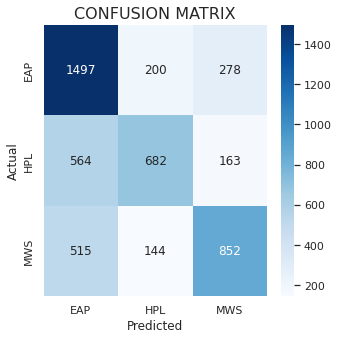

In [25]:
conf_mat = confusion_matrix(y_test, y_pred)
conf_mat
fig, ax = plt.subplots(figsize=(5,5))
sns.heatmap(conf_mat, annot=True, cmap="Blues", fmt='d',
            xticklabels=df['author'].unique(), 
            yticklabels=df['author'].unique())
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title("CONFUSION MATRIX", size=16);

### ROC AUC 

In [34]:
from sklearn.metrics import roc_auc_score

def roc_auc_score_multiclass(actual_class, pred_class, average = "macro"):
    
    #creating a set of all the unique classes using the actual class list
    unique_class = set(actual_class)
    roc_auc_dict = {}
    for per_class in unique_class:
        
        #creating a list of all the classes except the current class 
        other_class = [x for x in unique_class if x != per_class]

        #marking the current class as 1 and all other classes as 0
        new_actual_class = [0 if x in other_class else 1 for x in actual_class]
        new_pred_class = [0 if x in other_class else 1 for x in pred_class]

        #using the sklearn metrics method to calculate the roc_auc_score
        roc_auc = roc_auc_score(new_actual_class, new_pred_class, average = average)
        roc_auc_dict[per_class] = roc_auc

    return roc_auc_dict

In [35]:
roc_auc_dict = roc_auc_score_multiclass(y_test, y_pred)
roc_auc_dict

{0: 0.6942270677995491, 1: 0.6926753958956581, 2: 0.7167729205683147}

### Accuracy per class

In [26]:
# Get the confusion matrix
cm = confusion_matrix(y_true, y_pred)

# We will store the results in a dictionary for easy access later
per_class_accuracies = {}

# Calculate the accuracy for each one of our classes
for idx, cls in enumerate(label_dict):
    # True negatives are all the samples that are not our current GT class (not the current row) 
    # and were not predicted as the current class (not the current column)
    true_negatives = np.sum(np.delete(np.delete(cm, idx, axis=0), idx, axis=1))
    
    # True positives are all the samples of our current GT class that were predicted as such
    true_positives = cm[idx, idx]
    
    # The accuracy for the current class is ratio between correct predictions to all predictions
    per_class_accuracies[cls] = (true_positives + true_negatives) / np.sum(cm)

In [27]:
per_class_accuracies

{'EAP': 0.681920326864147,
 'HPL': 0.7812053115423901,
 'MWS': 0.7752808988764045}

### Always confuse which F1 score choose in classfication ,here are some awesome points to remember


>1. Suppose you have a balanced dataset and want an easily understandable metric for overall performance regardless of the class. In that case, you can go with accuracy, which is essentially our micro F1 score.
>2. If you have an imbalanced dataset but want to assign greater contribution to classes with more examples in the dataset, then the weighted average is preferred.
>3. if you are working with an imbalanced dataset where all classes are equally important, using the macro average would be a good choice as it treats all classes equally.

**Output per class F-1 score:**

In [43]:
f1_score(y_true, y_pred, average=None)

array([0.65787739, 0.56016427, 0.60770328])



**Micro averaged F1 Score:** calculate macro-averaged precision score and macro-averaged recall score and then take there harmonic mean

In [44]:
f1_score(y_true, y_pred, average='micro')

0.6192032686414709

**Macro averaged F1 Score:** calculate f1 score of every class and then average them

In [42]:
f1_score(y_true, y_pred, average='macro')

0.6085816472196796

## OR

In [73]:
conf_mat

array([[1497,  200,  278],
       [ 564,  682,  163],
       [ 515,  144,  852]])

In [88]:
conf_mat
##TP: The actual value and predicted value should be the same. So concerning Setosa class, the value of cell 1 is the TP value.
TP=np.diag(conf_mat)
##FN: The sum of values of corresponding rows except the TP value
FN= np.sum(conf_mat, axis = 1)-TP
##FP : The sum of values of corresponding column except the TP value.
FP= np.sum(conf_mat, axis = 0)-TP
##TN: The sum of values of all columns and row except the values of that class that we are calculating the values for.
TN=np.sum(conf_mat)-(FP + FN + TP)

In [103]:
d=pd.DataFrame(df['label'].unique(),columns=['label'])
d['TP']=TP
d['FP']=FP
d['FN']=FN
d['Precison']=d['TP']/(d['TP']+d['FP'])
d['Recall']=d['TP']/(d['TP']+d['FN'])
d['F1-Score']= 2 * ((d['Precison']*d['Recall'])/(d['Precison']+d['Recall']))
d['Macro Avg F1-Score'] =sum(d['F1-Score']) /3
d['Micro Avg F1-Score'] =sum(d['TP'])/(sum(d['TP'])+0.5*(sum(d['FP'])+sum(d['FN'])))
d['Support']=[1975,1409,1511]  ## dict(pd.DataFrame(y_test).value_counts()) : {(0,): 1975, (2,): 1511, (1,): 1409}
d['Support Proportion']=d['Support']/len(y_test)
d['Wtd Avg F1-Score'] =sum(d['F1-Score']*d['Support Proportion'])
d

,label,TP,FP,FN,Precison,Recall,F1-Score,Macro Avg F1-Score,Micro Avg F1-Score,Support,Support Proportion,Wtd Avg F1-Score
0,0,1497,1079,478,0.581134,0.757975,0.657877,0.608582,0.619203,1975,0.403473,0.614263
1,1,682,344,727,0.664717,0.484031,0.560164,0.608582,0.619203,1409,0.287845,0.614263
2,2,852,441,659,0.658933,0.563865,0.607703,0.608582,0.619203,1511,0.308682,0.614263
